In [1]:
import pandas as pd
import numpy as np
import re
import gzip
import json
import swifter
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2   # <<< NEW

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords, opinion_lexicon
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk import pos_tag

# === NLTK Setup ===
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('opinion_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_percept

True

In [2]:
!pip install vaderSentiment
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
# === 1. Load Data ===
metadata_path = r"C:\Master\datasets\meta_Cell_Phones_and_Accessories.json.gz"
metadata_df = pd.read_json(metadata_path, lines=True, compression='gzip')

reviews_path = r"C:\Master\datasets\Cell_Phones_and_Accessories.json.gz"

def read_limited_json_gz(file_path, limit=1_000_000):
    data = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= limit:
                break
            data.append(json.loads(line))
    return pd.DataFrame(data)

reviews_df = read_limited_json_gz(reviews_path, limit=1_000_000)
df = pd.merge(reviews_df, metadata_df, on='asin', how='inner')

In [4]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,...,feature,rank,also_view,details,main_cat,similar_item,date,price,imageURL,imageURLHighRes
0,5.0,True,"07 17, 2014",A236WRQL1MB9HM,7391002801,Morningstar,Beautiful item; received timely. Thank you.,Five Stars,1405555200,NaN,...,"[Item is Brand New, See Description for Detail...","[>#1,978,999 in Tools & Home Improvement (See ...",[],{},Tools & Home Improvement,,"September 22, 2014",,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,1.0,True,"12 29, 2017",AN04BLRG7BD8I,7391002801,J. Inman,Had this for 2 weeks. Had to replace screen p...,Outer ring very flimsy.,1514505600,NaN,...,"[Item is Brand New, See Description for Detail...","[>#1,978,999 in Tools & Home Improvement (See ...",[],{},Tools & Home Improvement,,"September 22, 2014",,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
2,1.0,True,"12 26, 2017",A3PHYA8A965CYU,7391002801,Morgan Epperson,The apple is not centered in the hole on the b...,"Pretty, but doesnt fit well.",1514246400,NaN,...,"[Item is Brand New, See Description for Detail...","[>#1,978,999 in Tools & Home Improvement (See ...",[],{},Tools & Home Improvement,,"September 22, 2014",,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
3,1.0,True,"12 24, 2017",A3N778P1L4YH9Y,7391002801,McKenna Clark,Case is cheaply made. If you aren't using an a...,Case is cheaply made. If you aren't using an ...,1514073600,2,...,"[Item is Brand New, See Description for Detail...","[>#1,978,999 in Tools & Home Improvement (See ...",[],{},Tools & Home Improvement,,"September 22, 2014",,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,5.0,True,"12 14, 2017",A3PHJYND753HBC,7391002801,Amazon Customer,This case is a really good thing. When you're ...,"Very low price, unbelievably high quality",1513209600,NaN,...,"[Item is Brand New, See Description for Detail...","[>#1,978,999 in Tools & Home Improvement (See ...",[],{},Tools & Home Improvement,,"September 22, 2014",,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [5]:
# Drop unused columns
columns_to_drop = [
    "reviewTime", "unixReviewTime", "vote", "rank", "also_view", "details",
    "similar_item", "date", "price", "imageURL", "imageURLHighRes","details",
    "image", "tech1", "also_buy", "tech2", "fit", "style", "category",
    "main_cat", "feature", "description"
]
df = df.drop(columns=columns_to_drop, errors='ignore')

In [6]:
# Fill missing & remove duplicates
df['reviewerName'] = df['reviewerName'].fillna('NAN')
df['reviewText'] = df['reviewText'].fillna('NAN')
df['summary'] = df['summary'].fillna('NAN')
df = df.drop_duplicates(subset='reviewText', keep='first')

In [7]:
df.head()

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,title,brand
0,5.0,True,A236WRQL1MB9HM,7391002801,Morningstar,Beautiful item; received timely. Thank you.,Five Stars,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory
1,1.0,True,AN04BLRG7BD8I,7391002801,J. Inman,Had this for 2 weeks. Had to replace screen p...,Outer ring very flimsy.,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory
2,1.0,True,A3PHYA8A965CYU,7391002801,Morgan Epperson,The apple is not centered in the hole on the b...,"Pretty, but doesnt fit well.",Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory
3,1.0,True,A3N778P1L4YH9Y,7391002801,McKenna Clark,Case is cheaply made. If you aren't using an a...,Case is cheaply made. If you aren't using an ...,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory
4,5.0,True,A3PHJYND753HBC,7391002801,Amazon Customer,This case is a really good thing. When you're ...,"Very low price, unbelievably high quality",Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory


In [8]:
df.shape

(928301, 9)

In [9]:
import re
import string

# Function to clean text
def clean_text(text):
    # 1.  (lowercase)
    text = text.lower()

    # 2.  (example: https://xyz.com)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # 3. (@username) dan hashtag (#topik)
    text = re.sub(r"@\w+|#\w+", '', text)

    # 4. Delete numbers
    text = re.sub(r'\d+', '', text)

    # 5. Remove punctuation marks (.,!? etc.)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 6. Remove non-ASCII characters (including emojis, strange characters)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # 7. Remove excess spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply function to all data
df['clean_text'] = df['reviewText'].apply(clean_text)

# Example of cleaning results
df[['reviewText', 'clean_text']].head(10)

,reviewText,clean_text
0,Beautiful item; received timely. Thank you.,beautiful item received timely thank you
1,Had this for 2 weeks. Had to replace screen p...,had this for weeks had to replace screen prote...
2,The apple is not centered in the hole on the b...,the apple is not centered in the hole on the b...
3,Case is cheaply made. If you aren't using an a...,case is cheaply made if you arent using an app...
4,This case is a really good thing. When you're ...,this case is a really good thing when youre ti...
5,I use it for a long time and the look of the c...,i use it for a long time and the look of the c...
6,I like it very much. High-quality material mak...,i like it very much highquality material makes...
7,"Just love it! I won't never regret, I've spent...",just love it i wont never regret ive spent mon...
8,"This case is for people, who knows that there'...",this case is for people who knows that theres ...
9,The case is stylish and luxurious! I love it! ...,the case is stylish and luxurious i love it th...


In [10]:
# Count duplicates before removal
duplicate_count = df.duplicated(subset='clean_text').sum()
print(f"Number of duplicate rows based on 'clean_text': {duplicate_count}")
# Remove duplicates
df = df.drop_duplicates(subset='clean_text', keep='first')
print(f" The size of the data after removal': {df}")

Number of duplicate rows based on 'clean_text': 10586
 The size of the data after removal':          overall  verified      reviewerID        asin  \
0            5.0      True  A236WRQL1MB9HM  7391002801   
1            1.0      True   AN04BLRG7BD8I  7391002801   
2            1.0      True  A3PHYA8A965CYU  7391002801   
3            1.0      True  A3N778P1L4YH9Y  7391002801   
4            5.0      True  A3PHJYND753HBC  7391002801   
...          ...       ...             ...         ...   
1006282      2.0      True   A4X2FKCQN4ZU8  B008S16BU6   
1006283      3.0      True   AO533Y0I6W24P  B008S16BU6   
1006284      5.0      True   AHI9NU37K1T15  B008S16BU6   
1006285      4.0      True  A270C8ULPWKKZX  B008S16BU6   
1006286      3.0      True  A271UTTMR9VMWY  B008S16BU6   

                   reviewerName  \
0                   Morningstar   
1                      J. Inman   
2               Morgan Epperson   
3                 McKenna Clark   
4               Amazon Customer   
.

In [11]:
english_stopwords = [
    # Personal pronouns
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves',
    'you', "you're", "you've", "you'll", "you'd", 'your', 'yours',
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
    'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its',
    'itself', 'they', 'them', 'their', 'theirs', 'themselves',

    # Question words
    'what', 'which', 'who', 'whom', 'this', 'that', "that'll",
    'these', 'those', 'when', 'where', 'why', 'how',

    # Common verbs (be, have, do, modals)
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
    'can', 'will', 'shall', 'would', 'should', 'could', 'may',
    'might', 'must',

    # Conjunctions & prepositions
    'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while',
    'of', 'at', 'by', 'for', 'with', 'about', 'against',
    'between', 'into', 'through', 'during', 'before', 'after',
    'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
    'on', 'off', 'over', 'under',

    # Determiners & quantifiers
    'a', 'an', 'the', 'all', 'any', 'both', 'each', 'few',
    'more', 'most', 'other', 'some', 'such',

    # Negations
    'no', 'nor', 'not', "don't", "doesn't", "didn't",
    "isn't", "aren't", "wasn't", "weren't",
    "haven't", "hasn't", "hadn't", "won't", "wouldn't",
    "can't", "couldn't", "shouldn't", "mightn't",
    "mustn't", "shan't",

    # Time & sequence
    'again', 'further', 'then', 'once', 'now',

    # Degree / comparison
    'only', 'own', 'same', 'so', 'than', 'too', 'very',

    # Contractions & variants
    'd', 'll', 'm', 'o', 're', 've', 'y', 's', 't',

    # Polite / filler words
    'hi', 'hello', 'hey', 'ok', 'okay', 'yes', 'no',
    'thanks', 'thank', 'welcome', 'please',
    'etc', 'etc.', 'via', 'regards', 'dear',
    'best', 'sir', 'madam',

    # Extended contractions (common English forms)
    "aren’t", "can’t", "could’ve", "couldn’t", "didn’t",
    "doesn’t", "don’t", "hadn’t", "hasn’t", "haven’t",
    "he’d", "he’ll", "he’s", "how’d", "how’ll", "how’s",
    "i’d", "i’ll", "i’m", "i’ve", "it’d", "it’ll", "it’s",
    "let’s", "might’ve", "mightn’t", "must’ve", "mustn’t",
    "shan’t", "she’d", "she’ll", "she’s", "should’ve",
    "shouldn’t", "that’d", "that’s", "there’d", "there’s",
    "they’d", "they’ll", "they’re", "they’ve", "we’d",
    "we’ll", "we’re", "we’ve", "what’d", "what’s",
    "when’d", "when’s", "where’d", "where’s",
    "who’d", "who’ll", "who’s", "why’d", "why’s",
    "would’ve",

    # Slang / short forms
    'lol', 'omg', 'btw', 'fyi', 'pls', 'thx', 'u', 'ur',
    'r', 'im', 'ya', 'yup', 'nah'
]

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # remove mentions
    text = re.sub(r'http\S+|www\S+', '', text)  # remove URLs
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)  # remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove special characters
    text = text.strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in english_stopwords]
    return ' '.join(tokens)

# Apply cleaning function

print("\nCleaning text...")
df['cleaned_text'] = df['reviewText'].astype(str).apply(clean_text)
print("Text cleaning completed!")


Cleaning text...
Text cleaning completed!


In [13]:
# VADER + TextBlob setup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk

nltk.download('vader_lexicon')
nltk.download('punkt')

vader = SentimentIntensityAnalyzer()

# === 2. Define label functions ===
vader = SentimentIntensityAnalyzer()

def vader_label(text, pos_thresh=0.05, neg_thresh=-0.05):
    score = vader.polarity_scores(text)['compound']
    if score >= pos_thresh:
        return "positive"
    elif score <= neg_thresh:
        return "negative"
    else:
        return "neutral"

def textblob_label(text, pos_thresh=0.05, neg_thresh=-0.05):
    score = TextBlob(text).sentiment.polarity
    if score >= pos_thresh:
        return "positive"
    elif score <= neg_thresh:
        return "negative"
    else:
        return "neutral"

# === 3. Apply both labelers ===
df['vader_label'] = df['cleaned_text'].apply(vader_label)
df['textblob_label'] = df['cleaned_text'].apply(textblob_label)

# === 4. Keep only agreement cases ===
df_agree = df[df['vader_label'] == df['textblob_label']].copy()
df_agree['label'] = df_agree['vader_label']  # final label

print(f"Original dataset size: {len(df)}")
print(f"After agreement filter: {len(df_agree)}")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Original dataset size: 917715
After agreement filter: 715462


In [14]:
# Add VADER and TextBlob scores to df_agree
df_agree['vader_score'] = df_agree['cleaned_text'].apply(lambda x: vader.polarity_scores(str(x))['compound'])
df_agree['textblob_score'] = df_agree['cleaned_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Vader and TextBlob labels are already created earlier, but just to be safe:
df_agree['vader_label'] = df_agree['cleaned_text'].apply(vader_label)
df_agree['textblob_label'] = df_agree['cleaned_text'].apply(textblob_label)

# Final label = agreed label (already exists as df_agree['label'])
df_agree['final_label'] = df_agree['label']

# Show a few samples
df_agree[['cleaned_text',
          'vader_score','vader_label',
          'textblob_score','textblob_label',
          'final_label']].head(10)

,cleaned_text,vader_score,vader_label,textblob_score,textblob_label,final_label
0,beautiful item received timely,0.5994,positive,0.850000,positive,positive
2,apple centered hole back fit iphone plus properly,0.3612,positive,0.133333,positive,positive
3,case cheaply made arent using apple charger fi...,0.3612,positive,0.200000,positive,positive
4,case really good thing youre tired bright mass...,0.7264,positive,0.250000,positive,positive
5,use long time look case hasnt changed thats hi...,0.6369,positive,0.203333,positive,positive
6,like much highquality material makes case dura...,0.7845,positive,0.344444,positive,positive
7,just love wont never regret ive spent money ca...,0.8596,positive,0.333333,positive,positive
8,case people knows theres nothing better wellma...,0.4203,positive,0.500000,positive,positive
9,case stylish luxurious love amazing product,0.8402,positive,0.533333,positive,positive
10,exactly needed getting difficult find,-0.3612,negative,-0.125000,negative,negative


In [15]:
df_agree_neg = df_agree[df_agree['final_label'] == 'negative']

# Display first 15 rows
df_agree_neg[['cleaned_text',
              'vader_score','vader_label',
              'textblob_score','textblob_label',
              'final_label']].head(15)

,cleaned_text,vader_score,vader_label,textblob_score,textblob_label,final_label
10,exactly needed getting difficult find,-0.3612,negative,-0.125000,negative,negative
27,got cover today mail hour rhinestones already ...,-0.7096,negative,-0.112500,negative,negative
43,dont care gave gift just expected,-0.6167,negative,-0.100000,negative,negative
45,love look phone negative difficulty removing p...,-0.6597,negative,-0.166667,negative,negative
60,item reach expectation look similar picture we...,-0.3818,negative,-0.093750,negative,negative
104,hate looks cheap plastic rhinestones fell taki...,-0.5719,negative,-0.200000,negative,negative
149,received case crystals missing keep falling do...,-0.1200,negative,-0.200000,negative,negative
193,product little bit ruff iphone imagine others ...,-0.4062,negative,-0.160227,negative,negative
211,bad bling case basically plastic junk fake cry...,-0.6249,negative,-0.600000,negative,negative
243,ordered cases one come decontrol one cracked m...,-0.6908,negative,-0.400000,negative,negative


In [16]:
df_agree_neg = df_agree[df_agree['final_label'] == 'neutral']

# Display first 15 rows
df_agree_neg[['cleaned_text',
              'vader_score','vader_label',
              'textblob_score','textblob_label',
              'final_label']].head(15)

,cleaned_text,vader_score,vader_label,textblob_score,textblob_label,final_label
13,met expectations,0.0,neutral,0.000000e+00,neutral,neutral
17,excelente,0.0,neutral,0.000000e+00,neutral,neutral
39,everything came supposed durable case rhinesto...,0.0,neutral,0.000000e+00,neutral,neutral
108,said take days month another mother never got ...,0.0,neutral,0.000000e+00,neutral,neutral
140,bow fell multiple times keep gluing back would...,0.0,neutral,0.000000e+00,neutral,neutral
179,day sabe phone just go aout,0.0,neutral,0.000000e+00,neutral,neutral
206,still havent received case money taken account...,0.0,neutral,0.000000e+00,neutral,neutral
355,order item received blling crystal bow transpa...,0.0,neutral,0.000000e+00,neutral,neutral
369,month still recivie phone case ordering anythi...,0.0,neutral,0.000000e+00,neutral,neutral
371,bling fell second day case phone dont think ev...,0.0,neutral,0.000000e+00,neutral,neutral


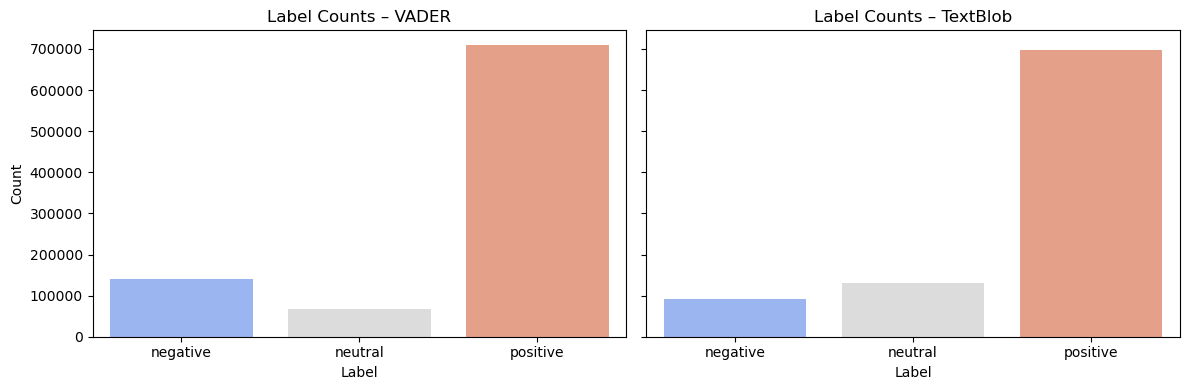

Percentages (%):
          VADER  TextBlob
negative   15.4       9.9
neutral     7.2      14.2
positive   77.4      75.9


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

dist = pd.DataFrame({
    'VADER': df['vader_label'].value_counts(),
    'TextBlob': df['textblob_label'].value_counts()
}).reindex(['negative','neutral','positive'])

dist_pct = (dist.div(dist.sum(axis=0), axis=1) * 100).round(1)

fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
sns.barplot(x=dist.index, y=dist['VADER'], ax=ax[0], palette='coolwarm')
ax[0].set_title('Label Counts – VADER'); ax[0].set_xlabel('Label'); ax[0].set_ylabel('Count')
sns.barplot(x=dist.index, y=dist['TextBlob'], ax=ax[1], palette='coolwarm')
ax[1].set_title('Label Counts – TextBlob'); ax[1].set_xlabel('Label')
plt.tight_layout(); plt.show()

print('Percentages (%):')
print(dist_pct)

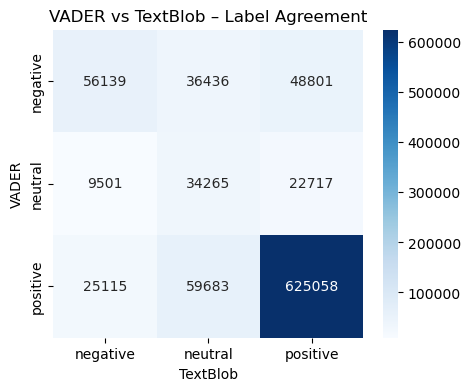

Overall agreement: 78.0%


In [18]:
cm = pd.crosstab(df['vader_label'], df['textblob_label'], dropna=False)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('VADER vs TextBlob – Label Agreement'); plt.xlabel('TextBlob'); plt.ylabel('VADER')
plt.show()

agree_rate = (df['vader_label'] == df['textblob_label']).mean()*100
print(f'Overall agreement: {agree_rate:.1f}%')

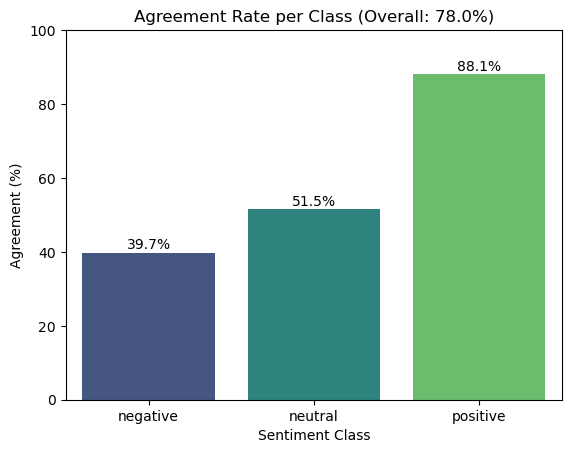

In [62]:
df['agree'] = df['vader_label'] == df['textblob_label']
agree_rate = (df['agree'].mean()*100).round(1)

class_agree = (df.groupby('vader_label')['agree'].mean()*100).reindex(['negative','neutral','positive'])

sns.barplot(x=class_agree.index, y=class_agree.values, palette='viridis')
plt.title(f"Agreement Rate per Class (Overall: {agree_rate}%)")
plt.ylabel("Agreement (%)")
plt.xlabel("Sentiment Class")
plt.ylim(0,100)
for i,v in enumerate(class_agree.values):
    plt.text(i, v+1, f"{v:.1f}%", ha='center')
plt.show()


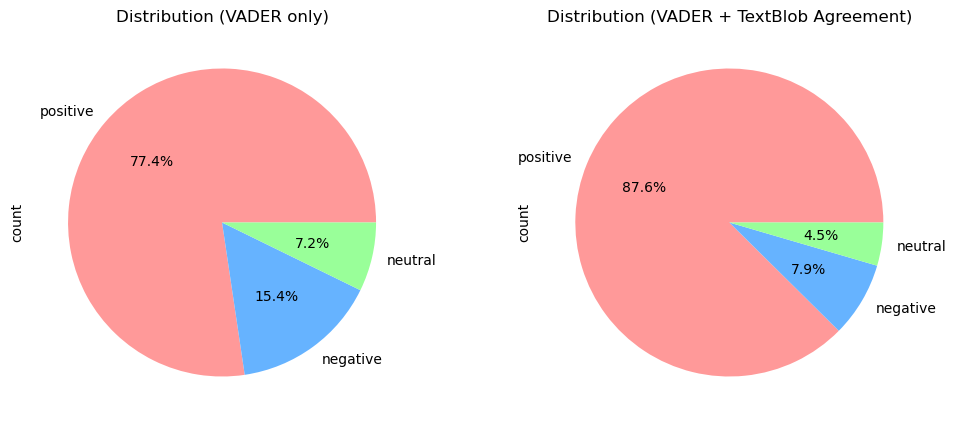

In [63]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

df['vader_label'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], colors=['#ff9999','#66b3ff','#99ff99'])
ax[0].set_title("Distribution (VADER only)")

df_agree['label'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1], colors=['#ff9999','#66b3ff','#99ff99'])
ax[1].set_title("Distribution (VADER + TextBlob Agreement)")

plt.show()


In [26]:
# Count the number of samples per sentiment
sentiment_counts = df_agree['label'].value_counts()
print(sentiment_counts)

label
positive    625058
negative     56139
neutral      34265
Name: count, dtype: int64


In [28]:
#--- Data Preprocessing ---#

import re
import string

# Convert your list to a set for faster lookups
ENGLISH_STOPWORDS = set(english_stopwords)

def preprocess(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # remove non-ASCII
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    
    # Remove stopwords
    tokens = [word for word in text.split() if word not in ENGLISH_STOPWORDS]
    return ' '.join(tokens)

# Apply preprocessing
df_agree['preprocessed_text'] = df_agree['cleaned_text'].astype(str).apply(preprocess)

In [29]:
#text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
#text = re.sub(r"@\w+|#\w+", '', text)  # remove mentions & hashtags

In [30]:
df_agree = df_agree.drop_duplicates(subset=['preprocessed_text'])
df_agree.head()

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,title,brand,clean_text,cleaned_text,vader_label,textblob_label,label,preprocessed_text
0,5.0,True,A236WRQL1MB9HM,7391002801,Morningstar,Beautiful item; received timely. Thank you.,Five Stars,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,beautiful item received timely thank you,beautiful item received timely,positive,positive,positive,beautiful item received timely
2,1.0,True,A3PHYA8A965CYU,7391002801,Morgan Epperson,The apple is not centered in the hole on the b...,"Pretty, but doesnt fit well.",Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,the apple is not centered in the hole on the b...,apple centered hole back fit iphone plus properly,positive,positive,positive,apple centered hole back fit iphone plus properly
3,1.0,True,A3N778P1L4YH9Y,7391002801,McKenna Clark,Case is cheaply made. If you aren't using an a...,Case is cheaply made. If you aren't using an ...,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,case is cheaply made if you arent using an app...,case cheaply made arent using apple charger fi...,positive,positive,positive,case cheaply made arent using apple charger fi...
4,5.0,True,A3PHJYND753HBC,7391002801,Amazon Customer,This case is a really good thing. When you're ...,"Very low price, unbelievably high quality",Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,this case is a really good thing when youre ti...,case really good thing youre tired bright mass...,positive,positive,positive,case really good thing youre tired bright mass...
5,5.0,True,A1SUHZO4ONJ5YC,7391002801,Amazon Customer,I use it for a long time and the look of the c...,Premium quality!,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,i use it for a long time and the look of the c...,use long time look case hasnt changed thats hi...,positive,positive,positive,use long time look case hasnt changed thats hi...


In [31]:
df_agree.shape

(708527, 15)

### EDA

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

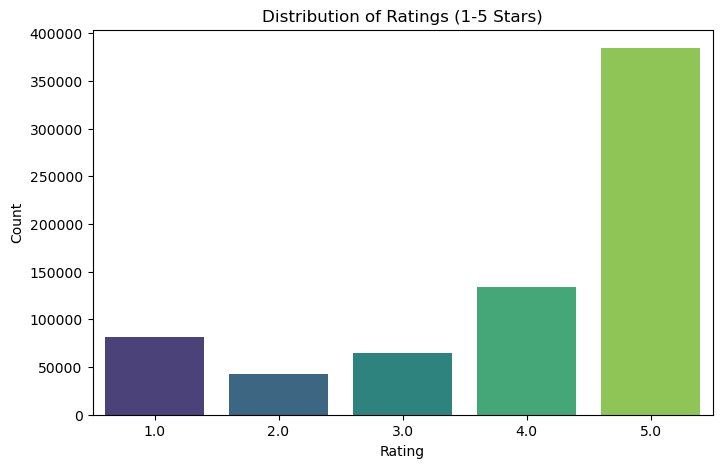

In [52]:
# --------------------------
#  Rating Distribution
# --------------------------
plt.figure(figsize=(8,5))
sns.countplot(x='overall', data=df_agree, palette='viridis')
plt.title("Distribution of Ratings (1-5 Stars)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

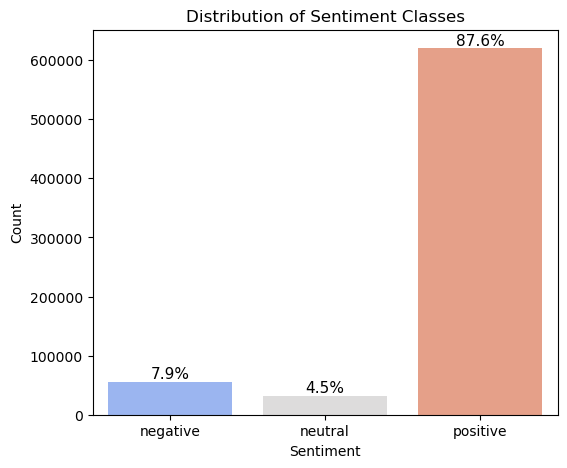

In [40]:
# --------------------------
# Sentiment Distribution with Percentages
# --------------------------
plt.figure(figsize=(6,5))
ax = sns.countplot(
    x='label',
    data=df_agree,
    order=['negative','neutral','positive'],
    palette='coolwarm'
)

# Add percentage labels
total = len(df_agree)
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.1f}%'
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom',
                fontsize=11, color='black')

plt.title("Distribution of Sentiment Classes")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


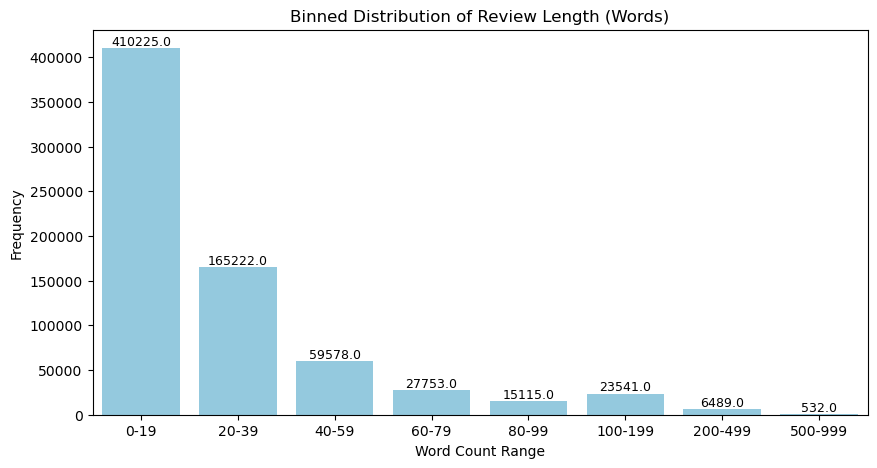

In [44]:
# Create bins for word counts
bins = [0, 20, 40, 60, 80, 100, 200, 500, 1000]
labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
df_agree['word_count_bin'] = pd.cut(df_agree['review_length_words'], bins=bins, labels=labels, include_lowest=True)

# Plot as barplot
plt.figure(figsize=(10,5))
ax = sns.countplot(x='word_count_bin', data=df_agree, color='skyblue')

# Add count labels above each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 5,
            str(height), ha='center', va='bottom', fontsize=9, color='black')

plt.title("Binned Distribution of Review Length (Words)")
plt.xlabel("Word Count Range")
plt.ylabel("Frequency")
plt.show()


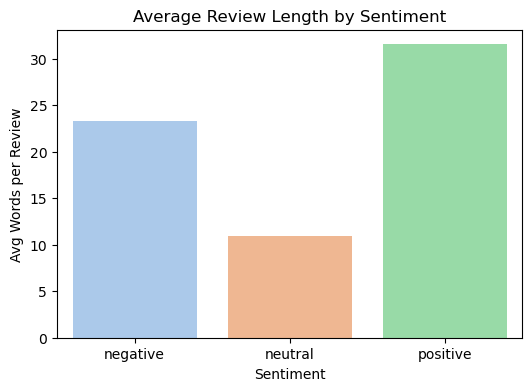

In [53]:
# --------------------------
# 5. Average Review Length by Sentiment
# --------------------------
avg_length = df_agree.groupby('label')['review_length_words'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='label', y='review_length_words', data=avg_length, palette='pastel')
plt.title("Average Review Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Avg Words per Review")
plt.show()

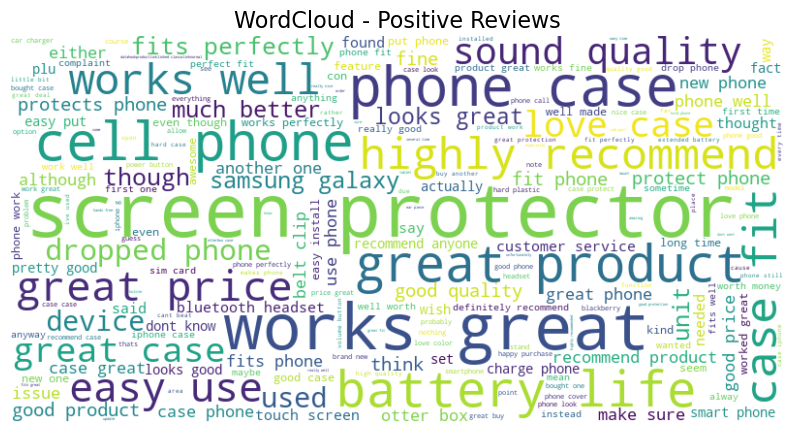

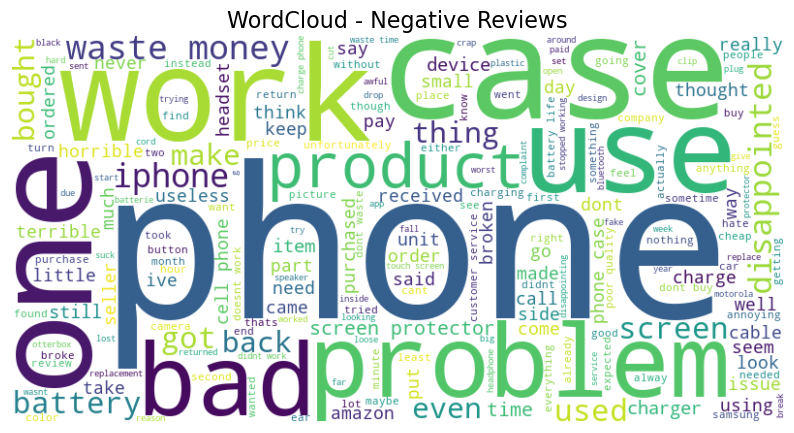

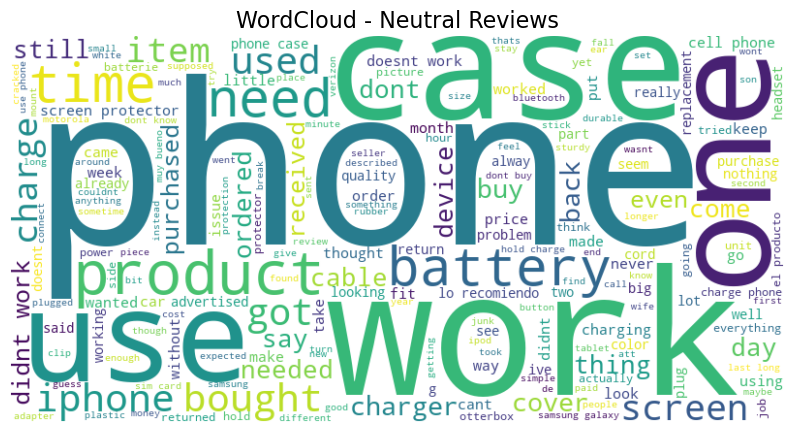

In [46]:
# --------------------------
# . WordClouds by Sentiment
# --------------------------
stopwords = set(STOPWORDS)

def show_wordcloud(data, title):
    wc = WordCloud(width=800, height=400, background_color='white',
                   stopwords=stopwords, colormap='viridis').generate(" ".join(data))
    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

show_wordcloud(df_agree[df_agree['label']=='positive']['preprocessed_text'], "WordCloud - Positive Reviews")
show_wordcloud(df_agree[df_agree['label']=='negative']['preprocessed_text'], "WordCloud - Negative Reviews")
show_wordcloud(df_agree[df_agree['label']=='neutral']['preprocessed_text'], "WordCloud - Neutral Reviews")


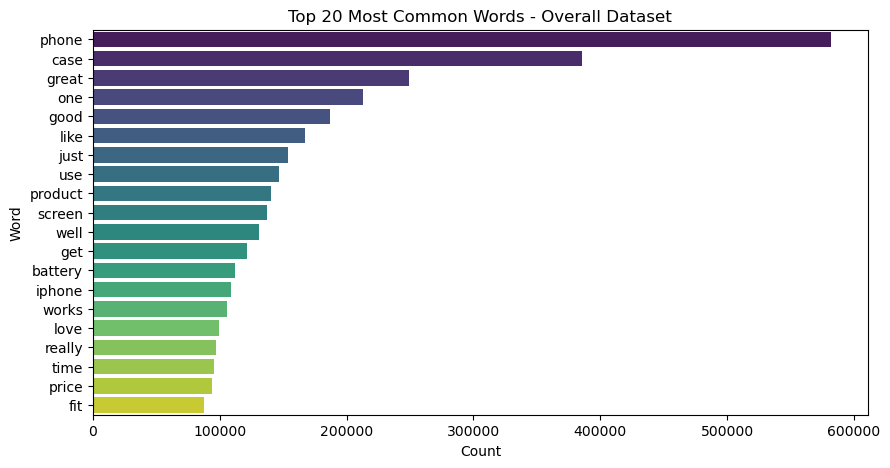

In [48]:
# --------------------------
# Overall Most Common Words
# --------------------------
from collections import Counter

def plot_top_words_overall(texts, n=20):
    all_words = " ".join(texts).split()
    word_freq = Counter(all_words)
    common_words = pd.DataFrame(word_freq.most_common(n), columns=['word','count'])

    plt.figure(figsize=(10,5))
    sns.barplot(x='count', y='word', data=common_words, palette='viridis')
    plt.title(f"Top {n} Most Common Words - Overall Dataset")
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.show()

# Call function on full dataset
plot_top_words_overall(df_agree['preprocessed_text'], n=20)

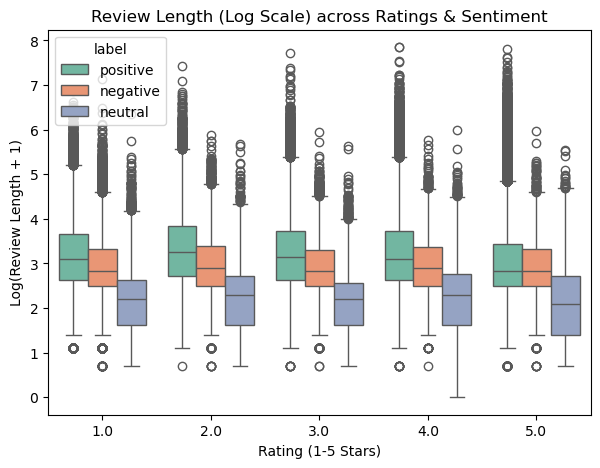

In [50]:
#---Correlation: Rating vs Sentiment
# --------------------------
plt.figure(figsize=(7,5))
sns.boxplot(x='overall', y=np.log1p(df_agree['review_length_words']), hue='label', data=df_agree, palette='Set2')
plt.title("Review Length (Log Scale) across Ratings & Sentiment")
plt.xlabel("Rating (1-5 Stars)")
plt.ylabel("Log(Review Length + 1)")
plt.show()

In [55]:
import pandas as pd

# Create review length (word count)
df_agree['review_length'] = df_agree['preprocessed_text'].apply(lambda x: len(str(x).split()))

# Select columns for summary
summary = df_agree[['overall', 'review_length']].describe()

summary

,overall,review_length
count,708527.000000,708527.000000
mean,3.984332,29.955965
std,1.382597,43.145571
min,1.000000,0.000000
25%,3.000000,11.000000
50%,5.000000,17.000000
75%,5.000000,33.000000
max,5.000000,2561.000000


In [51]:
df_agree.head()

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,title,brand,clean_text,cleaned_text,vader_label,textblob_label,label,preprocessed_text,review_length_words,review_length_chars,word_count_bin
0,5.0,True,A236WRQL1MB9HM,7391002801,Morningstar,Beautiful item; received timely. Thank you.,Five Stars,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,beautiful item received timely thank you,beautiful item received timely,positive,positive,positive,beautiful item received timely,4,30,0-19
2,1.0,True,A3PHYA8A965CYU,7391002801,Morgan Epperson,The apple is not centered in the hole on the b...,"Pretty, but doesnt fit well.",Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,the apple is not centered in the hole on the b...,apple centered hole back fit iphone plus properly,positive,positive,positive,apple centered hole back fit iphone plus properly,8,49,0-19
3,1.0,True,A3N778P1L4YH9Y,7391002801,McKenna Clark,Case is cheaply made. If you aren't using an a...,Case is cheaply made. If you aren't using an ...,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,case is cheaply made if you arent using an app...,case cheaply made arent using apple charger fi...,positive,positive,positive,case cheaply made arent using apple charger fi...,19,112,0-19
4,5.0,True,A3PHJYND753HBC,7391002801,Amazon Customer,This case is a really good thing. When you're ...,"Very low price, unbelievably high quality",Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,this case is a really good thing when youre ti...,case really good thing youre tired bright mass...,positive,positive,positive,case really good thing youre tired bright mass...,17,107,0-19
5,5.0,True,A1SUHZO4ONJ5YC,7391002801,Amazon Customer,I use it for a long time and the look of the c...,Premium quality!,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,i use it for a long time and the look of the c...,use long time look case hasnt changed thats hi...,positive,positive,positive,use long time look case hasnt changed thats hi...,11,61,0-19


In [73]:
#-- Balancing --#

df_majority = df_agree[df_agree['label'] == 'neutral']
df_pos = df_agree[df_agree['label'] == 'positive']
df_neg = df_agree[df_agree['label'] == 'negative']

df_pos_up = resample(df_pos, replace=True, n_samples=len(df_majority), random_state=42)
df_neg_up = resample(df_neg, replace=True, n_samples=len(df_majority), random_state=42)
df_balanced = pd.concat([df_majority, df_pos_up, df_neg_up])

df_balanced = df_balanced.dropna(subset=['preprocessed_text'])
df_balanced = df_balanced[df_balanced['preprocessed_text'].str.strip() != '']

In [74]:
df_balanced.head()

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,title,brand,clean_text,...,textblob_label,label,preprocessed_text,review_length_words,review_length_chars,word_count_bin,review_length,vader_score,textblob_score,final_label
13,5.0,True,A107O6W0Q98CAT,7391002801,Suzanne Henderson #1410864,met expectations,met expectations,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,met expectations,...,neutral,neutral,met expectations,2,16,0-19,2,0.0,0.0,neutral
17,5.0,True,A1EHXZBPIPARC2,7391002801,Guillermo Chavez,Excelente!!!,Five Stars,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,excelente,...,neutral,neutral,excelente,1,9,0-19,1,0.0,0.0,neutral
39,3.0,True,A2XPAU57KKYYRQ,7508492919,SmithIII,Everything came as it was supposed to but not ...,Durability,MinisDesign 3d Bling Crystal Bow Transparent C...,ELEGANI,everything came as it was supposed to but not ...,...,neutral,neutral,everything came supposed durable case rhinesto...,10,74,0-19,10,0.0,0.0,neutral
108,1.0,True,ATFNF6ZCX0KLZ,7508492919,Pen Name,it said it would take 4-17 days as it is and t...,I NEVER GOT THE PHONE CASE!!!!,MinisDesign 3d Bling Crystal Bow Transparent C...,ELEGANI,it said it would take days as it is and then a...,...,neutral,neutral,said take days month another mother never got ...,10,56,0-19,10,0.0,0.0,neutral
140,1.0,True,A317T1S6EM6G23,7508492919,The Sound,The bow fell off multiple times I had to keep ...,Don't waste your money or invest in glue,MinisDesign 3d Bling Crystal Bow Transparent C...,ELEGANI,the bow fell off multiple times i had to keep ...,...,neutral,neutral,bow fell multiple times keep gluing back would...,16,93,0-19,16,0.0,0.0,neutral


In [76]:
df_balanced.shape

(96176, 22)

C:\Users\oalba\AppData\Local\Temp\ipykernel_21280\4049620433.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(x).title() for x in counts.index])
C:\Users\oalba\AppData\Local\Temp\ipykernel_21280\4049620433.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(x).title() for x in counts.index])


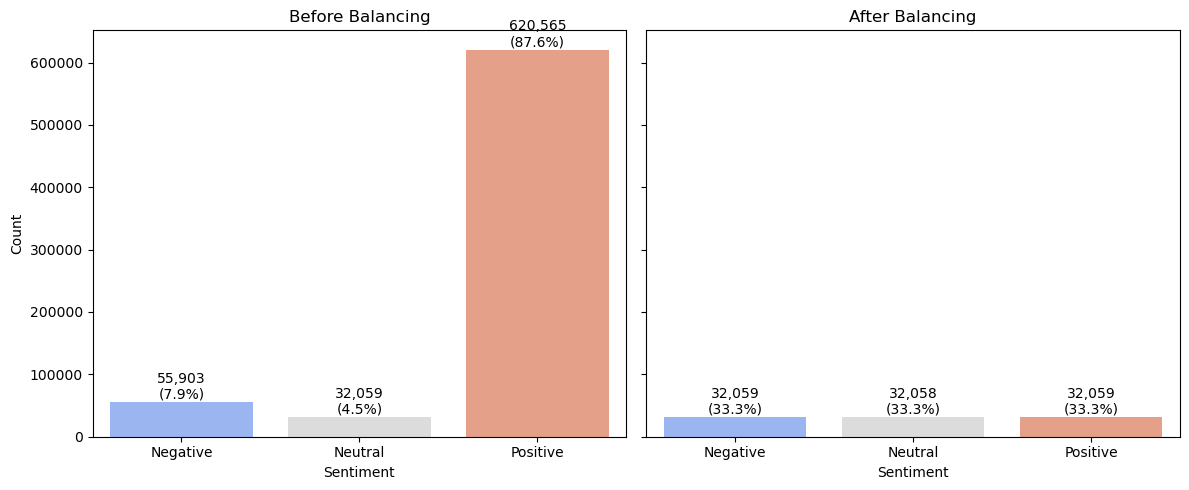

Before: {'positive': 620565, 'negative': 55903, 'neutral': 32059}
After : {'positive': 32059, 'negative': 32059, 'neutral': 32058}


In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ----- Helper function: barplot with counts + % -----
def plot_label_dist(df, ax, title, label_col='label', order=None):
    # counts & percentages
    counts = df[label_col].value_counts()
    if order:
        counts = counts.reindex([c for c in order if c in counts.index])
    perc = (counts / counts.sum() * 100).round(1)

    # plot
    sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='coolwarm')
    ax.set_title(title)
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('Count')

    # add text annotations: count + %
    for i, (c, p) in enumerate(zip(counts.values, perc.values)):
        ax.text(i, c, f'{c:,}\n({p}%)', ha='center', va='bottom', fontsize=10)

    # clean x-axis labels
    ax.set_xticklabels([str(x).title() for x in counts.index])

# ----- Plot before vs. after -----
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Before balancing: original df_agree
plot_label_dist(df_agree, axes[0], 'Before Balancing', order=['negative','neutral','positive'])

# After balancing: df_balanced
plot_label_dist(df_balanced, axes[1], 'After Balancing', order=['negative','neutral','positive'])

plt.tight_layout()
plt.show()

# Quick check in console
print("Before:", df_agree['label'].value_counts().to_dict())
print("After :", df_balanced['label'].value_counts().to_dict())


### before the features 

Akurasi (Naive Bayes): 0.80
Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.89      0.82      6389
     neutral       0.93      0.61      0.74      6352
    positive       0.78      0.91      0.84      6495

    accuracy                           0.80     19236
   macro avg       0.82      0.80      0.80     19236
weighted avg       0.82      0.80      0.80     19236



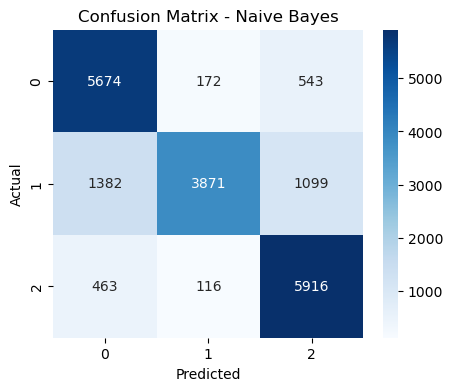

K-Fold Mean Accuracy: 0.80, Std: 0.01


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd

# === TF-IDF Vectorization ===
vectorizer = TfidfVectorizer(max_features=15000)
X = vectorizer.fit_transform(df_balanced['preprocessed_text'])
y = df_balanced['label']  # or 'predicted_sentiment' if using VADER/TextBlob labels

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Naive Bayes Model ===
nb = MultinomialNB()
nb.fit(X_train, y_train)

# === Predictions & Evaluation ===
y_pred = nb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Akurasi (Naive Bayes): {acc:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# === K-Fold Cross Validation ===
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(nb, X, y, cv=kfold, scoring='accuracy')
print(f"K-Fold Mean Accuracy: {cv_scores.mean():.2f}, Std: {cv_scores.std():.2f}")

Akurasi (Naive Bayes): 0.80
Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.87      0.81      6389
     neutral       0.91      0.62      0.74      6352
    positive       0.78      0.90      0.83      6495

    accuracy                           0.80     19236
   macro avg       0.82      0.80      0.80     19236
weighted avg       0.82      0.80      0.80     19236



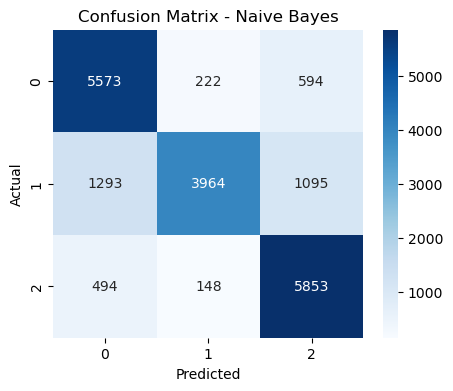

K-Fold Mean Accuracy: 0.80, Std: 0.01


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd

# === TF-IDF Vectorization ===
vectorizer = TfidfVectorizer(max_features=15000)
X = vectorizer.fit_transform(df_balanced['preprocessed_text'])
y = df_balanced['label']  # or 'predicted_sentiment' if using VADER/TextBlob labels

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Naive Bayes Model ===
nb = MultinomialNB(alpha=0.1)
nb.fit(X_train, y_train)

# === Predictions & Evaluation ===
y_pred = nb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Akurasi (Naive Bayes): {acc:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# === K-Fold Cross Validation ===
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(nb, X, y, cv=kfold, scoring='accuracy')
print(f"K-Fold Mean Accuracy: {cv_scores.mean():.2f}, Std: {cv_scores.std():.2f}")

Accuracy (LinearSVC): 0.95
Classification Report:
              precision    recall  f1-score   support

    negative       0.95      0.96      0.96      6389
     neutral       0.94      0.93      0.93      6352
    positive       0.97      0.97      0.97      6495

    accuracy                           0.95     19236
   macro avg       0.95      0.95      0.95     19236
weighted avg       0.95      0.95      0.95     19236



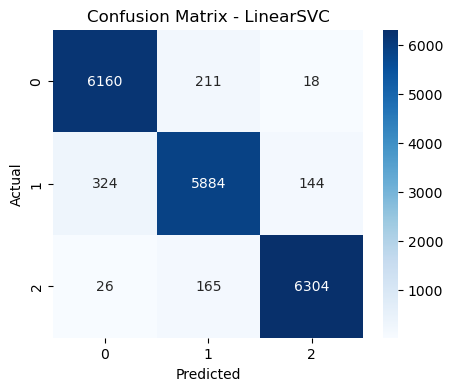

In [79]:
# SVM 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import pandas as pd

# === TF-IDF Vectorization ===
vectorizer = TfidfVectorizer(max_features=15000)
X = vectorizer.fit_transform(df_balanced['preprocessed_text'])
y = df_balanced['label']  # or 'predicted_sentiment' if using VADER/TextBlob labels

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === LinearSVC Model ===
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)

# === Predictions & Evaluation ===
y_pred = linear_svc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy (LinearSVC): {acc:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - LinearSVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### apply the features 

In [80]:
# --- Imports ---
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk
# --- NLTK resources (safe downloads) ---
for pkg in ["vader_lexicon", "opinion_lexicon", "punkt", "averaged_perceptron_tagger"]:
    try:
        nltk.data.find(f"tokenizers/{pkg}") if pkg=="punkt" else nltk.data.find(f"sentiment/{pkg}") if "lexicon" in pkg else nltk.data.find(f"taggers/{pkg}")
    except LookupError:
        nltk.download(pkg)

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon
from nltk import pos_tag, word_tokenize

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [81]:
class POSFeatures(BaseEstimator, TransformerMixin):
    """Counts of POS buckets: nouns, verbs, adjectives, adverbs per doc (min-max scaled)."""
    def __init__(self):
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        feats = self._extract(X)
        self.scaler.fit(feats)
        return self

    def transform(self, X):
        feats = self._extract(X)
        feats = self.scaler.transform(feats)
        return csr_matrix(feats)

    def _extract(self, X):
        X = pd.Series(X).fillna("").astype(str)
        rows = []
        for text in X:
            tokens = word_tokenize(text)
            tags = pos_tag(tokens, tagset=None)
            n_noun = sum(t[1].startswith("NN") for t in tags)
            n_verb = sum(t[1].startswith("VB") for t in tags)
            n_adj  = sum(t[1].startswith("JJ") for t in tags)
            n_adv  = sum(t[1].startswith("RB") for t in tags)
            rows.append([n_noun, n_verb, n_adj, n_adv])
        return np.asarray(rows, dtype=float)


class ReviewFeatures(BaseEstimator, TransformerMixin):
    """Simple review meta features (non-negative): char_len, word_len, !, ?, CAPS ratio."""
    def __init__(self):
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        feats = self._extract(X)
        self.scaler.fit(feats)
        return self

    def transform(self, X):
        feats = self._extract(X)
        feats = self.scaler.transform(feats)
        return csr_matrix(feats)

    def _extract(self, X):
        X = pd.Series(X).fillna("").astype(str)
        rows = []
        for text in X:
            char_len = len(text)
            words = re.findall(r"\b\w+\b", text)
            word_len = len(words)
            exclam = text.count("!")
            qmark = text.count("?")
            caps = sum(1 for c in text if c.isupper())
            caps_ratio = (caps / char_len) if char_len else 0.0
            rows.append([char_len, word_len, exclam, qmark, caps_ratio])
        return np.asarray(rows, dtype=float)


class PolarityCountFeatures(BaseEstimator, TransformerMixin):
    """Counts of positive/negative lexicon hits (non-negative, scaled)."""
    def __init__(self):
        self.pos_set = set(opinion_lexicon.positive())
        self.neg_set = set(opinion_lexicon.negative())
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        feats = self._extract(X)
        self.scaler.fit(feats)
        return self

    def transform(self, X):
        feats = self._extract(X)
        feats = self.scaler.transform(feats)
        return csr_matrix(feats)

    def _extract(self, X):
        X = pd.Series(X).fillna("").astype(str)
        rows = []
        for text in X:
            tokens = [w.lower() for w in re.findall(r"\b[a-zA-Z']+\b", text)]
            p = sum(w in self.pos_set for w in tokens)
            n = sum(w in self.neg_set for w in tokens)
            rows.append([p, n])
        return np.asarray(rows, dtype=float)

In [ ]:
#HERE


=== Final Test Accuracy ===
0.8211

=== Classification Report ===
              precision    recall  f1-score   support

    negative       0.79      0.91      0.85      6412
     neutral       0.93      0.64      0.76      6412
    positive       0.78      0.92      0.84      6412

    accuracy                           0.82     19236
   macro avg       0.84      0.82      0.82     19236
weighted avg       0.84      0.82      0.82     19236


=== Confusion Matrix ===


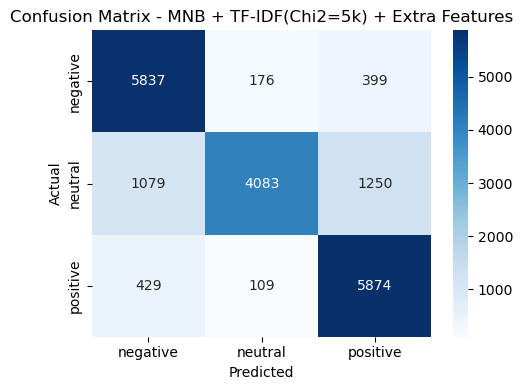

In [94]:
# =========================
# Vectorizer + FeatureUnion + NB
# =========================
# TF-IDF + chi2 selection
tfidf_chi2 = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english",
                              sublinear_tf=True,
                              max_features=15000,
                              ngram_range=(1, 2))),
    ("chi2", SelectKBest(chi2, k=5000))
])

combined_features = FeatureUnion([
    ("tfidf_sel", tfidf_chi2),  # sparse
    ("pos", POSFeatures()),       # csr_matrix
    ("review_feats", ReviewFeatures()),  # csr_matrix
    ("polarity", PolarityCountFeatures())  # csr_matrix
])

final_pipe = Pipeline([
    ("features", combined_features),
    ("nb", MultinomialNB(alpha=1))  # use your tuned alpha here
])
# =========================
# Fit & Evaluate
# =========================
# Assumes df_balanced has: 'preprocessed_text' and 'sentiment'
X = df_balanced["preprocessed_text"].fillna("").astype(str).values
y = df_balanced["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

final_pipe.fit(X_train, y_train)

y_pred = final_pipe.predict(X_test)
print("\n=== Final Test Accuracy ===")
print(f"{accuracy_score(y_test, y_pred):.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred, labels=final_pipe.classes_)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=final_pipe.classes_, yticklabels=final_pipe.classes_)
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix - MNB + TF-IDF(Chi2=5k) + Extra Features')
plt.tight_layout()
plt.show()


=== Final Test Accuracy ===
0.9496

=== Classification Report ===
              precision    recall  f1-score   support

    negative       0.94      0.95      0.95      6412
     neutral       0.93      0.93      0.93      6412
    positive       0.97      0.96      0.97      6412

    accuracy                           0.95     19236
   macro avg       0.95      0.95      0.95     19236
weighted avg       0.95      0.95      0.95     19236


=== Confusion Matrix ===


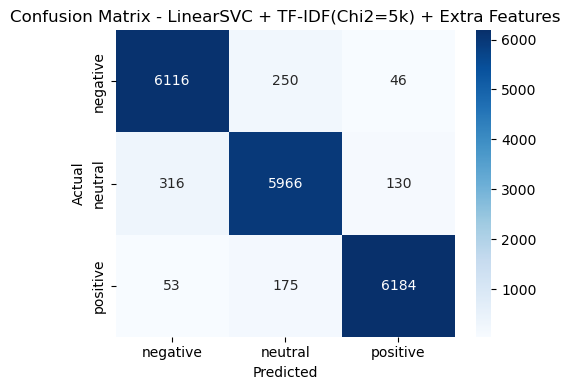

In [83]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# TF-IDF + chi2 selection
# =========================
tfidf_chi2 = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english",
                              sublinear_tf=True,
                              max_features=15000,
                              ngram_range=(1, 2))),
    ("chi2", SelectKBest(chi2, k=5000))
])

combined_features = FeatureUnion([
    ("tfidf_sel", tfidf_chi2),  # sparse
    ("pos", POSFeatures()),       # csr_matrix
    ("review_feats", ReviewFeatures()),  # csr_matrix
    ("polarity", PolarityCountFeatures())  # csr_matrix
])

# =========================
# Pipeline with LinearSVC
# =========================
final_pipe = Pipeline([
    ("features", combined_features),
    ("svm", LinearSVC())  # default LinearSVC, can tune C later
])

# =========================
# Fit & Evaluate
# =========================
X = df_balanced["preprocessed_text"].fillna("").astype(str).values
y = df_balanced["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

final_pipe.fit(X_train, y_train)

y_pred = final_pipe.predict(X_test)
print("\n=== Final Test Accuracy ===")
print(f"{accuracy_score(y_test, y_pred):.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred, labels=final_pipe.classes_)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=final_pipe.classes_, yticklabels=final_pipe.classes_)
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix - LinearSVC + TF-IDF(Chi2=5k) + Extra Features')
plt.tight_layout()
plt.show()


SVM       | k= 1000 | F1=0.9379±0.0009 | time=21.5s
SVM       | k= 3000 | F1=0.9435±0.0007 | time=19.6s
SVM       | k= 5000 | F1=0.9456±0.0006 | time=20.0s
SVM       | k= 8000 | F1=0.9453±0.0005 | time=19.7s
SVM       | k=10000 | F1=0.9445±0.0008 | time=19.9s
SVM       | k=12000 | F1=0.9437±0.0005 | time=20.3s
SVM       | k=15000 | F1=0.9426±0.0003 | time=20.7s
NB        | k= 1000 | F1=0.8021±0.0073 | time=17.5s
NB        | k= 3000 | F1=0.8076±0.0030 | time=17.8s
NB        | k= 5000 | F1=0.8070±0.0029 | time=18.0s
NB        | k= 8000 | F1=0.8057±0.0030 | time=17.6s
NB        | k=10000 | F1=0.8037±0.0032 | time=17.6s
NB        | k=12000 | F1=0.8020±0.0025 | time=17.7s
NB        | k=15000 | F1=0.8031±0.0018 | time=18.8s


,model,k,f1_macro_mean,f1_macro_std,cv_time_sec
7,NB,1000,0.8021,0.0073,17.4952
8,NB,3000,0.8076,0.0030,17.8156
9,NB,5000,0.8070,0.0029,17.9523
10,NB,8000,0.8057,0.0030,17.6255
11,NB,10000,0.8037,0.0032,17.5761
12,NB,12000,0.8020,0.0025,17.6698
13,NB,15000,0.8031,0.0018,18.8136
0,SVM,1000,0.9379,0.0009,21.4809
1,SVM,3000,0.9435,0.0007,19.6072
2,SVM,5000,0.9456,0.0006,20.0245


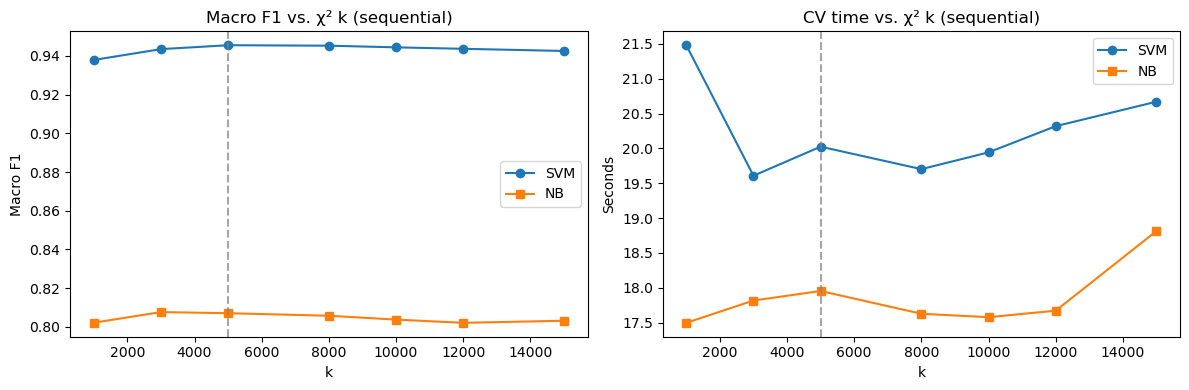

In [101]:
# --- Chi-square (χ²) feature selection: pick k (sequential, no parallel) ---
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

# Data
X_text = df_balanced['preprocessed_text'].astype(str)
y       = df_balanced['label']

# TF-IDF settings
tfidf_kwargs = dict(
    stop_words='english',
    ngram_range=(1, 2),
    max_features=15000,
    sublinear_tf=True
)

k_grid = [1000, 3000, 5000, 8000, 10000, 12000, 15000]

def eval_k_grid(model, model_name, k_values, cv_folds=3):
    rows = []
    skf = StratifiedKFold(cv_folds, shuffle=True, random_state=42)

    for k in k_values:
        pipe = Pipeline([
            ("tfidf", TfidfVectorizer(**tfidf_kwargs)),
            ("chi2",  SelectKBest(chi2, k=k)),
            ("clf",   model)
        ])

        t0 = time.time()
        # n_jobs=1 ensures no parallelism
        scores = cross_val_score(pipe, X_text, y,
                                 cv=skf, scoring='f1_macro', n_jobs=1)
        elapsed = time.time() - t0

        rows.append({
            "model": model_name,
            "k": k,
            "f1_macro_mean": scores.mean(),
            "f1_macro_std": scores.std(),
            "cv_time_sec": elapsed
        })
        print(f"{model_name:9s} | k={k:5d} | F1={scores.mean():.4f}±{scores.std():.4f} | time={elapsed:.1f}s")

    return pd.DataFrame(rows)

# Run models sequentially (no parallel folds)
res_svm = eval_k_grid(LinearSVC(), "SVM", k_grid)
res_nb  = eval_k_grid(MultinomialNB(), "NB",  k_grid)

results = pd.concat([res_svm, res_nb], ignore_index=True)
display(results.sort_values(["model","k"]).round(4))

# Plots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for model_name, marker in [("SVM", "o-"), ("NB", "s-")]:
    sub = results[results["model"] == model_name]
    ax[0].plot(sub["k"], sub["f1_macro_mean"], marker, label=model_name)
    ax[1].plot(sub["k"], sub["cv_time_sec"], marker, label=model_name)

for a in ax: a.axvline(5000, ls="--", color="gray", alpha=0.7)
ax[0].set_title("Macro F1 vs. χ² k (sequential)"); ax[0].set_xlabel("k"); ax[0].set_ylabel("Macro F1"); ax[0].legend()
ax[1].set_title("CV time vs. χ² k (sequential)");  ax[1].set_xlabel("k"); ax[1].set_ylabel("Seconds"); ax[1].legend()
plt.tight_layout(); plt.show()


### FEATURE ENGINEERING ANALYSIS

Vectorized once: shape=(96176, 30000), time=7.9s
k=  5000  F1=0.6017±0.0023  CV time=2.7s
k= 10000  F1=0.7491±0.0020  CV time=1.8s
k= 15000  F1=0.8501±0.0020  CV time=2.6s
k= 20000  F1=0.8915±0.0007  CV time=3.4s
k= 30000  F1=0.9410±0.0007  CV time=3.7s


,max_features,f1_macro_mean,f1_macro_std,fit_cv_sec,dimensionality,nnz_per_sample_mean
0,5000,0.601717,0.002315,2.678569,5000,3.621319
1,10000,0.749134,0.001980,1.830383,10000,7.394454
2,15000,0.850082,0.002027,2.575703,15000,11.072773
3,20000,0.891519,0.000693,3.369958,20000,14.830436
4,30000,0.941024,0.000687,3.659115,30000,22.134607


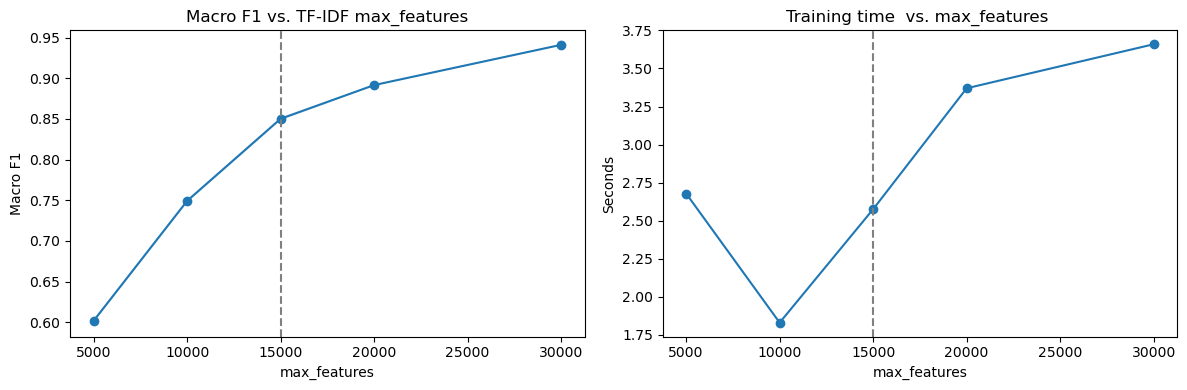

Top   5000 tokens cover 93.42% of all token occurrences in df_balanced.
Top  10000 tokens cover 96.52% of all token occurrences in df_balanced.
Top  15000 tokens cover 97.62% of all token occurrences in df_balanced.
Top  20000 tokens cover 98.21% of all token occurrences in df_balanced.
Top  30000 tokens cover 98.91% of all token occurrences in df_balanced.


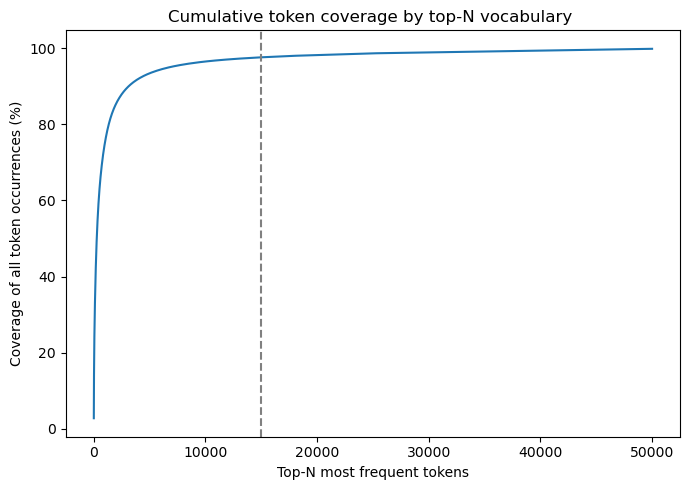

In [95]:
# ===== Fast TF-IDF cap study on df_balanced =====
import time, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score

# -----------------------------
# 0) Data
# -----------------------------
X_text = df_balanced['preprocessed_text'].astype(str)
y = df_balanced['label']  # expected: 'negative','neutral','positive'

# -----------------------------
# 1) Fit TF-IDF ONCE at max size
# -----------------------------
max_features_overall = 30000
vec = TfidfVectorizer(
    ngram_range=(1, 2),          # use (1,1) for a super-fast scan; (1,2) for final
    stop_words='english',
    max_features=max_features_overall,
    sublinear_tf=True
)

t0 = time.time()
X_full = vec.fit_transform(X_text).astype(np.float32)
print(f"Vectorized once: shape={X_full.shape}, time={time.time()-t0:.1f}s")

# Deterministic column order (as created by vectorizer)
feature_order = np.arange(X_full.shape[1])  # or use np.argsort(vec.idf_) for idf order

# -----------------------------
# 2) Evaluate LinearSVC on sliced feature caps
# -----------------------------
def eval_on_slices(sizes, cv_folds=3):
    rows = []
    skf = StratifiedKFold(cv_folds, shuffle=True, random_state=42)
    for k in sizes:
        Xk = X_full[:, feature_order[:k]]
        clf = LinearSVC()

        t0 = time.time()
        scores = cross_val_score(clf, Xk, y, cv=skf, scoring='f1_macro', n_jobs=-1)
        elapsed = time.time() - t0

        rows.append({
            'max_features': k,
            'f1_macro_mean': scores.mean(),
            'f1_macro_std': scores.std(),
            'fit_cv_sec': elapsed,
            'dimensionality': Xk.shape[1],
            'nnz_per_sample_mean': Xk.getnnz(axis=1).mean()
        })
        print(f"k={k:6d}  F1={scores.mean():.4f}±{scores.std():.4f}  CV time={elapsed:.1f}s")
    return pd.DataFrame(rows)

grid = [5000, 10000, 15000, 20000, 30000]
results = eval_on_slices(grid, cv_folds=3)
display(results)

# -----------------------------
# 3) Visualizations
# -----------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Macro-F1 vs max_features
ax[0].plot(results['max_features'], results['f1_macro_mean'], marker='o')
ax[0].fill_between(results['max_features'],
                   results['f1_macro_mean'] - results['f1_macro_std'],
                   results['f1_macro_mean'] + results['f1_macro_std'],
                   alpha=0.15)
ax[0].axvline(15000, ls='--', color='gray')
ax[0].set_title('Macro F1 vs. TF-IDF max_features')
ax[0].set_xlabel('max_features')
ax[0].set_ylabel('Macro F1')

# CV training time vs max_features
ax[1].plot(results['max_features'], results['fit_cv_sec'], marker='o')
ax[1].axvline(15000, ls='--', color='gray')
ax[1].set_title('Training time  vs. max_features ')
ax[1].set_xlabel('max_features')
ax[1].set_ylabel('Seconds')

plt.tight_layout()
plt.show()

# -----------------------------
# 4) Vocabulary-coverage check (for justification)
# -----------------------------
import re, collections
tok_pat = re.compile(r"\b[a-zA-Z']+\b")

freq = collections.Counter()
total_tokens = 0
for t in X_text:
    toks = tok_pat.findall(t)
    freq.update(w.lower() for w in toks)
    total_tokens += len(toks)

freq_df = pd.DataFrame(freq.items(), columns=['token', 'count']).sort_values('count', ascending=False)
freq_df['prop'] = freq_df['count'] / total_tokens
freq_df['cum_prop'] = freq_df['prop'].cumsum()

for k in grid:
    if k <= len(freq_df):
        cov = freq_df.iloc[:k]['prop'].sum() * 100
        print(f"Top {k:6d} tokens cover {cov:5.2f}% of all token occurrences in df_balanced.")

# Optional coverage curve
K = min(50000, len(freq_df))
x = np.arange(1, K+1)
y = (freq_df.iloc[:K]['cum_prop'].values * 100)
plt.figure(figsize=(7,5))
plt.plot(x, y)
plt.axvline(15000, ls='--', color='gray')
plt.title("Cumulative token coverage by top-N vocabulary ")
plt.xlabel("Top-N most frequent tokens")
plt.ylabel("Coverage of all token occurrences (%)")
plt.tight_layout()
plt.show()


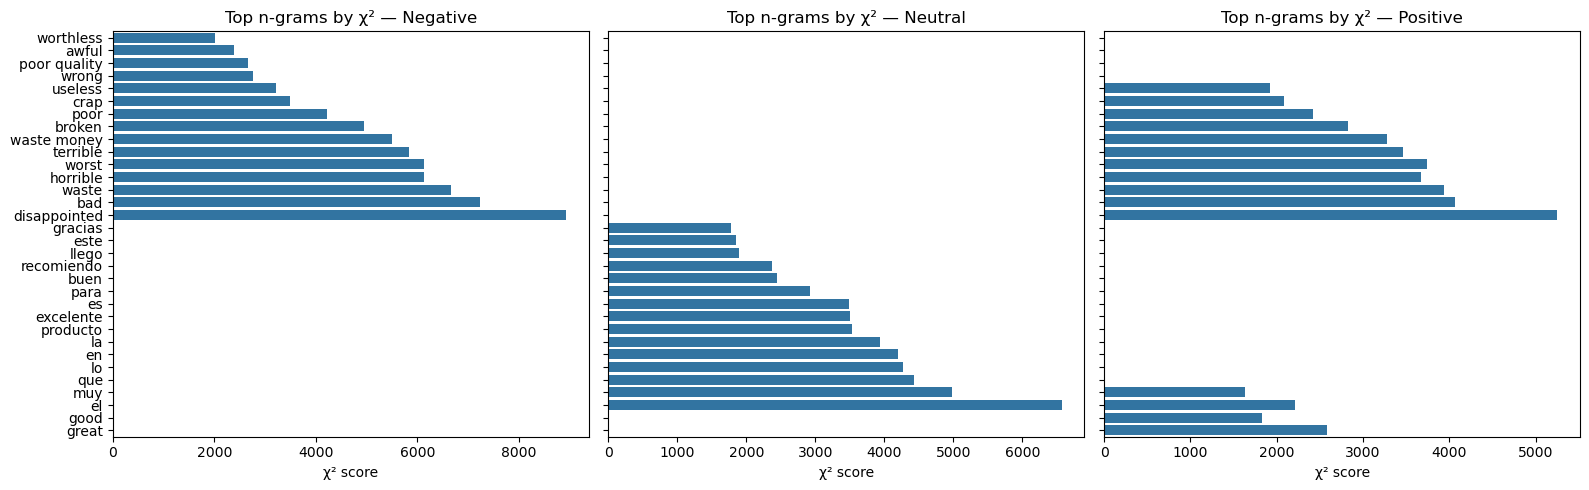

,class,term,chi2
0,negative,disappointed,8924.276593
1,negative,bad,7223.084207
2,negative,waste,6656.676606
3,negative,horrible,6138.964612
4,negative,worst,6125.086734
5,negative,terrible,5836.606336
6,negative,waste money,5504.597500
7,negative,broken,4951.186784
8,negative,poor,4222.844942
9,negative,crap,3487.350528


In [85]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

# 1) Vectorize text
X_text = df_agree['preprocessed_text'].astype(str)
y = df_agree['label']
labels = ['negative','neutral','positive']

tfidf = TfidfVectorizer(stop_words='english',
                        ngram_range=(1,2),           # unigrams + bigrams
                        max_features=15000,
                        sublinear_tf=True)
X = tfidf.fit_transform(X_text)
terms = np.array(tfidf.get_feature_names_out())

# 2) χ² per class (class vs rest)
def chi2_top_terms(target_label, k=20):
    mask = (y == target_label).values.astype(int)
    scores, _ = chi2(X, mask)
    idx = np.argsort(scores)[-k:][::-1]
    return pd.DataFrame({'term': terms[idx], 'chi2': scores[idx]})

# 3) Barplots (side-by-side)
fig, axes = plt.subplots(1, 3, figsize=(16,5), sharey=True)
for ax, lab in zip(axes, labels):
    topk = chi2_top_terms(lab, k=15)
    sns.barplot(data=topk.iloc[::-1], x='chi2', y='term', ax=ax)
    ax.set_title(f"Top n-grams by χ² — {lab.title()}")
    ax.set_xlabel("χ² score"); ax.set_ylabel("")
plt.tight_layout(); plt.show()

# 4) Table of top 10 per class
chi2_table = pd.concat(
    {lab: chi2_top_terms(lab, k=10) for lab in labels},
    names=['class']
).reset_index(level=0)
chi2_table

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


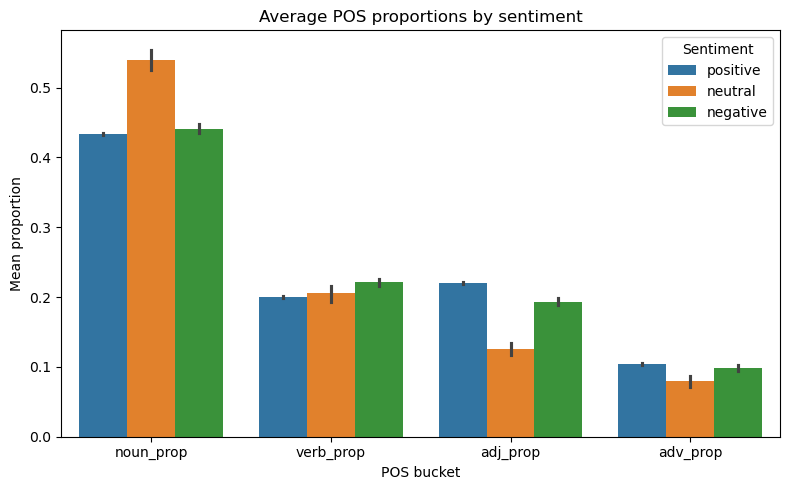

,noun_prop,verb_prop,adj_prop,adv_prop
label,,,,
negative,0.441,0.221,0.193,0.098
neutral,0.539,0.205,0.125,0.079
positive,0.433,0.200,0.220,0.104


In [86]:
import nltk, re
from nltk import pos_tag, word_tokenize
nltk.download('punkt'); nltk.download('averaged_perceptron_tagger')

def pos_props(text):
    toks = word_tokenize(str(text))
    tags = pos_tag(toks)
    n = max(1, len(toks))
    return pd.Series({
        'noun_prop': sum(t[1].startswith('NN') for t in tags)/n,
        'verb_prop': sum(t[1].startswith('VB') for t in tags)/n,
        'adj_prop' : sum(t[1].startswith('JJ') for t in tags)/n,
        'adv_prop' : sum(t[1].startswith('RB') for t in tags)/n
    })

# (sample for speed if huge)
idx = df_agree.sample(min(20000, len(df_agree)), random_state=42).index
pos_df = df_agree.loc[idx, 'preprocessed_text'].apply(pos_props)
pos_df['label'] = df_agree.loc[idx, 'label'].values

pos_melt = pos_df.melt(id_vars='label', var_name='pos', value_name='proportion')
plt.figure(figsize=(8,5))
sns.barplot(data=pos_melt, x='pos', y='proportion', hue='label')
plt.title("Average POS proportions by sentiment")
plt.xlabel("POS bucket"); plt.ylabel("Mean proportion")
plt.legend(title="Sentiment"); plt.tight_layout(); plt.show()

# Table: mean per class
pos_df.groupby('label')[['noun_prop','verb_prop','adj_prop','adv_prop']].mean().round(3)


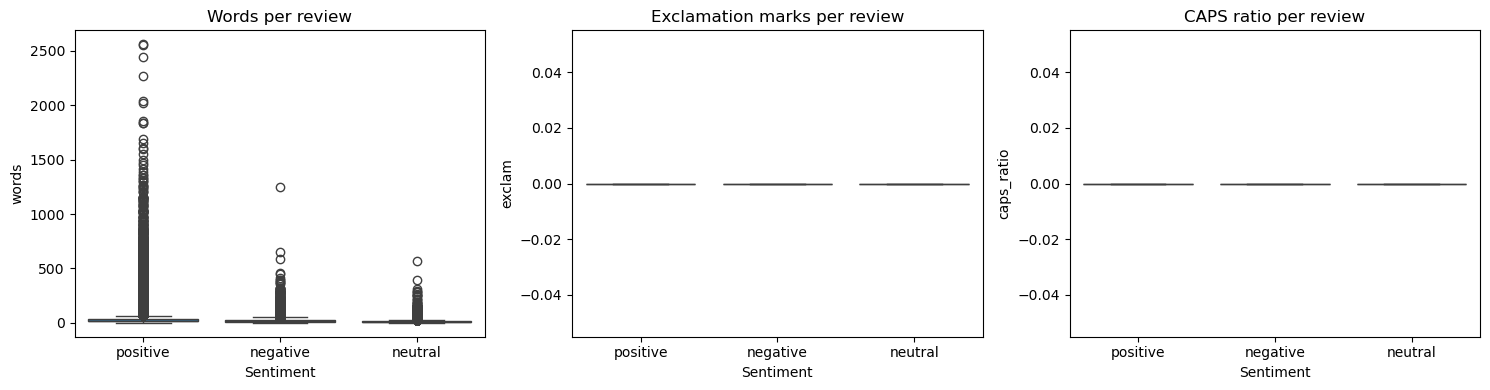

words                   chars                 exclam              \
            mean median     std     mean median      std   mean median  std   
label                                                                         
negative  23.258   16.0  23.525  153.891  106.0  160.037    0.0    0.0  0.0   
neutral   10.985    8.0  13.706   70.541   50.0   91.385    0.0    0.0  0.0   
positive  31.539   18.0  45.174  208.253  117.0  307.655    0.0    0.0  0.0   

         qmark             caps_ratio              
          mean median  std       mean median  std  
label                                              
negative   0.0    0.0  0.0        0.0    0.0  0.0  
neutral    0.0    0.0  0.0        0.0    0.0  0.0  
positive   0.0    0.0  0.0        0.0    0.0  0.0

In [87]:
def meta_feats(t):
    t = str(t)
    return pd.Series({
        'words': len(t.split()),
        'chars': len(t),
        'exclam': t.count('!'),
        'qmark': t.count('?'),
        'caps_ratio': sum(ch.isupper() for ch in t)/max(1,len(t))
    })
meta = df_agree['preprocessed_text'].apply(meta_feats)
meta['label'] = df_agree['label'].values

fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.boxplot(data=meta, x='label', y='words', ax=axes[0])
axes[0].set_title("Words per review")
sns.boxplot(data=meta, x='label', y='exclam', ax=axes[1])
axes[1].set_title("Exclamation marks per review")
sns.boxplot(data=meta, x='label', y='caps_ratio', ax=axes[2])
axes[2].set_title("CAPS ratio per review")
for ax in axes: ax.set_xlabel("Sentiment")
plt.tight_layout(); plt.show()

# Table: descriptive stats by class
(meta.groupby('label')[['words','chars','exclam','qmark','caps_ratio']]
     .agg(['mean','median','std']).round(3))


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


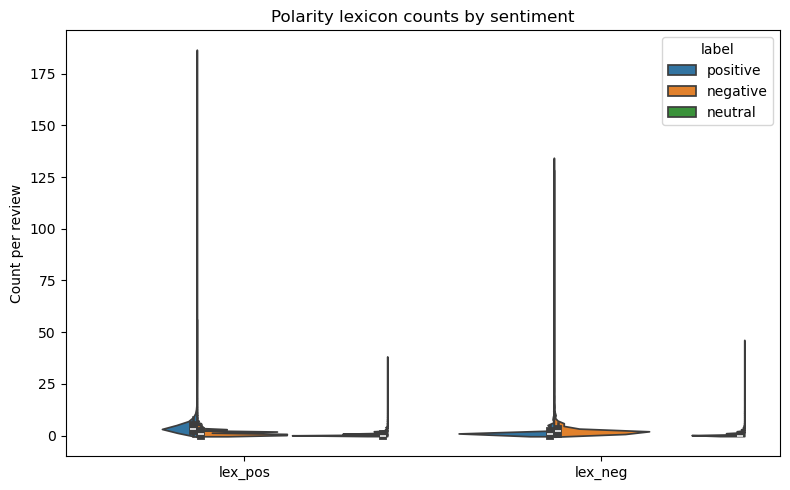

,lex_pos,lex_neg
label,,
negative,1.136,2.671
neutral,0.551,0.373
positive,4.245,1.337


In [88]:
from nltk.corpus import opinion_lexicon
nltk.download('opinion_lexicon')
pos_set, neg_set = set(opinion_lexicon.positive()), set(opinion_lexicon.negative())
token_pat = re.compile(r"\b[a-zA-Z']+\b")

def lex_counts(t):
    toks = [w.lower() for w in token_pat.findall(str(t))]
    return pd.Series({
        'lex_pos': sum(w in pos_set for w in toks),
        'lex_neg': sum(w in neg_set for w in toks)
    })

lex = df_agree['preprocessed_text'].apply(lex_counts)
lex['label'] = df_agree['label'].values
lex_m = lex.melt(id_vars='label', value_vars=['lex_pos','lex_neg'],
                 var_name='type', value_name='count')

plt.figure(figsize=(8,5))
sns.violinplot(data=lex_m, x='type', y='count', hue='label', split=True)
plt.title("Polarity lexicon counts by sentiment")
plt.xlabel(""); plt.ylabel("Count per review")
plt.tight_layout(); plt.show()

# Table: mean counts per class
lex.groupby('label')[['lex_pos','lex_neg']].mean().round(3)


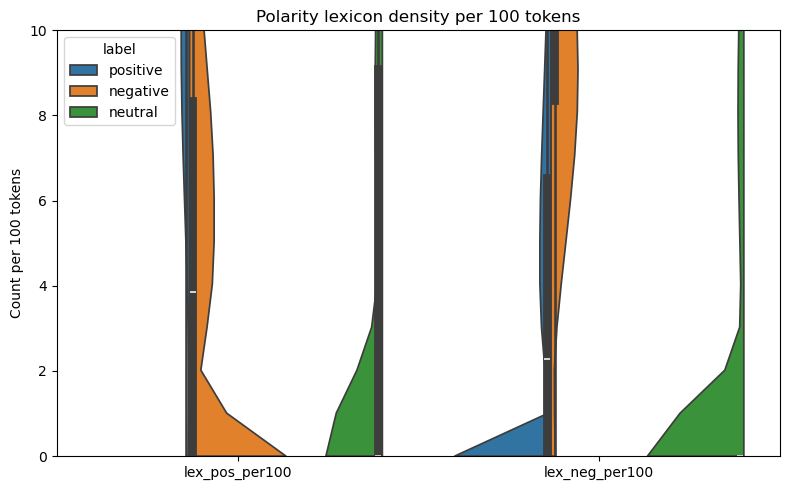

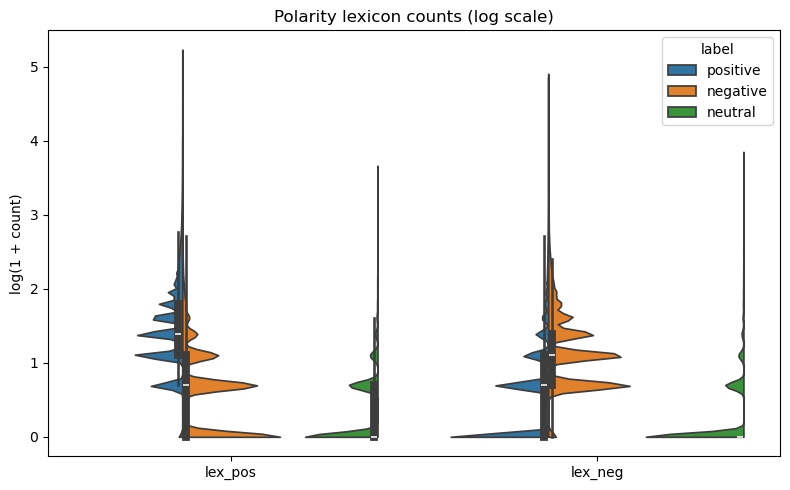

In [91]:
# normalize by length (per 100 tokens)
tok_counts = df_agree['preprocessed_text'].str.split().apply(len).replace(0, 1)
lex_norm = lex.copy()
lex_norm['lex_pos_per100'] = 100 * lex_norm['lex_pos'] / tok_counts
lex_norm['lex_neg_per100'] = 100 * lex_norm['lex_neg'] / tok_counts
lex_norm['label'] = df_agree['label'].values

lexm = lex_norm.melt(id_vars='label',
                     value_vars=['lex_pos_per100','lex_neg_per100'],
                     var_name='type', value_name='per100')

plt.figure(figsize=(8,5))
sns.violinplot(data=lexm, x='type', y='per100', hue='label', split=True, cut=0)
plt.ylim(0,10)  # focus on the bulk
plt.title("Polarity lexicon density per 100 tokens")
plt.ylabel("Count per 100 tokens"); plt.xlabel("")
plt.tight_layout(); plt.show()

# or: log scale on raw counts
plt.figure(figsize=(8,5))
sns.violinplot(data=lex_m, x='type', y=np.log1p(lex_m['count']), hue='label', split=True, cut=0)
plt.title("Polarity lexicon counts (log scale)")
plt.ylabel("log(1 + count)"); plt.xlabel("")
plt.tight_layout(); plt.show()

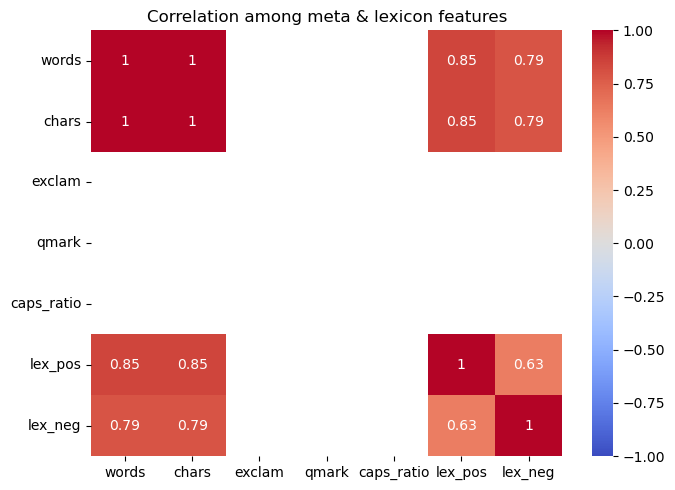

In [89]:
num = pd.concat([meta[['words','chars','exclam','qmark','caps_ratio']],
                 lex[['lex_pos','lex_neg']]], axis=1)

plt.figure(figsize=(7,5))
sns.heatmap(num.corr().round(2), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation among meta & lexicon features")
plt.tight_layout(); plt.show()


In [90]:
feature_table = pd.DataFrame([
    ["TF-IDF (1–2 grams)", "Weighted term importance; captures sentiment words/phrases (e.g., 'not good'). χ² highlights discriminative n-grams per class."],
    ["POS proportions (NN/VB/JJ/RB)", "Linguistic style; adjectives/adverbs carry sentiment, verbs/nouns describe aspects."],
    ["Meta: words/chars", "Verbosity and detail; longer reviews tend to be more expressive."],
    ["Meta: exclam, qmark, caps_ratio", "Emotion/intensity cues and emphasis markers."],
    ["Lexicon: pos/neg counts", "Direct polarity evidence from sentiment dictionaries; useful for short texts."]
], columns=["Feature group", "Rationale"])
feature_table


,Feature group,Rationale
0,TF-IDF (1–2 grams),Weighted term importance; captures sentiment w...
1,POS proportions (NN/VB/JJ/RB),Linguistic style; adjectives/adverbs carry sen...
2,Meta: words/chars,Verbosity and detail; longer reviews tend to b...
3,"Meta: exclam, qmark, caps_ratio",Emotion/intensity cues and emphasis markers.
4,Lexicon: pos/neg counts,Direct polarity evidence from sentiment dictio...


In [99]:
df_balanced[['preprocessed_text','review_length_words', 'review_length_chars', 'word_count_bin']].head(15)

,preprocessed_text,review_length_words,review_length_chars,word_count_bin
13,met expectations,2,16,0-19
17,excelente,1,9,0-19
39,everything came supposed durable case rhinesto...,10,74,0-19
108,said take days month another mother never got ...,10,56,0-19
140,bow fell multiple times keep gluing back would...,16,93,0-19
179,day sabe phone just go aout,6,27,0-19
206,still havent received case money taken account...,11,74,0-19
355,order item received blling crystal bow transpa...,9,63,0-19
369,month still recivie phone case ordering anythi...,8,53,0-19
371,bling fell second day case phone dont think ev...,13,74,0-19


### comparison

Naive Bayes Accuracy: 0.8165
Linear SVC Accuracy: 0.9483


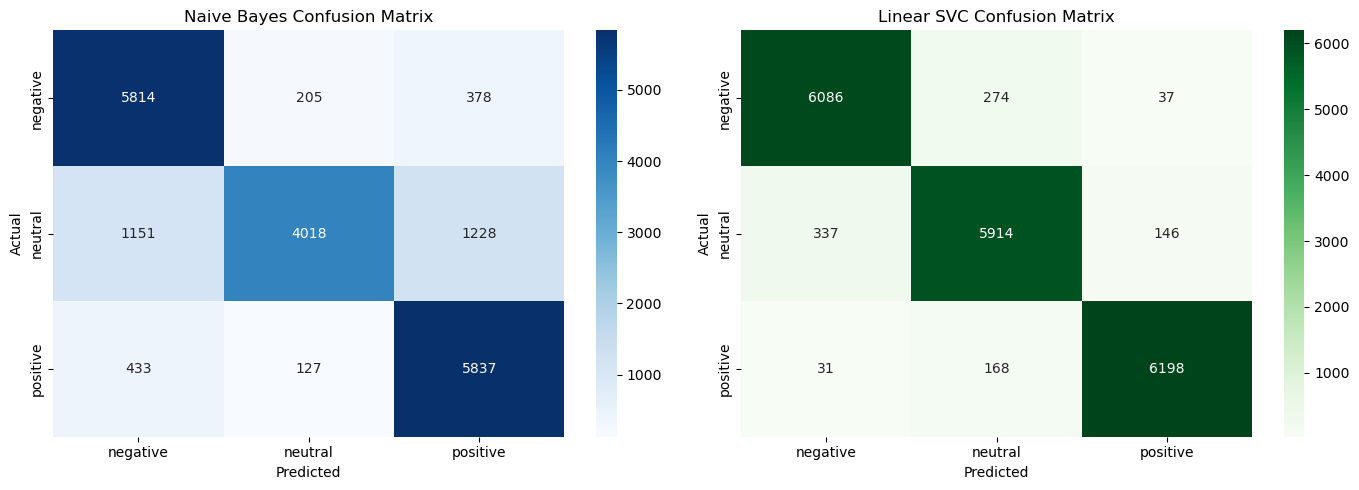

In [33]:
from sklearn.svm import LinearSVC

final_pipe_svm = Pipeline([
    ("features", combined_features),
    ("svm", LinearSVC())
])

# Fit SVM
final_pipe_svm.fit(X_train, y_train)

# Predictions
y_pred_svm = final_pipe_svm.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# NB predictions
y_pred_nb = final_pipe.predict(X_test)

# Accuracy
acc_nb = accuracy_score(y_test, y_pred_nb)
acc_svm = accuracy_score(y_test, y_pred_svm)

print(f"Naive Bayes Accuracy: {acc_nb:.4f}")
print(f"Linear SVC Accuracy: {acc_svm:.4f}")

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14,5))

cm_nb = confusion_matrix(y_test, y_pred_nb, labels=final_pipe.classes_)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=final_pipe.classes_, yticklabels=final_pipe.classes_, ax=axes[0])
axes[0].set_title("Naive Bayes Confusion Matrix")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=final_pipe_svm.classes_)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', xticklabels=final_pipe_svm.classes_, yticklabels=final_pipe_svm.classes_, ax=axes[1])
axes[1].set_title("Linear SVC Confusion Matrix")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [34]:
print("\n=== Naive Bayes Classification Report ===")
print(classification_report(y_test, y_pred_nb))

print("\n=== Linear SVC Classification Report ===")
print(classification_report(y_test, y_pred_svm))



=== Naive Bayes Classification Report ===
              precision    recall  f1-score   support

    negative       0.79      0.91      0.84      6397
     neutral       0.92      0.63      0.75      6397
    positive       0.78      0.91      0.84      6397

    accuracy                           0.82     19191
   macro avg       0.83      0.82      0.81     19191
weighted avg       0.83      0.82      0.81     19191


=== Linear SVC Classification Report ===
              precision    recall  f1-score   support

    negative       0.94      0.95      0.95      6397
     neutral       0.93      0.92      0.93      6397
    positive       0.97      0.97      0.97      6397

    accuracy                           0.95     19191
   macro avg       0.95      0.95      0.95     19191
weighted avg       0.95      0.95      0.95     19191



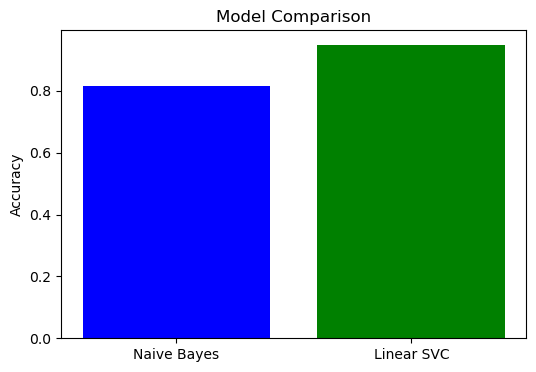

In [35]:
plt.figure(figsize=(6,4))
plt.bar(['Naive Bayes', 'Linear SVC'], [acc_nb, acc_svm], color=['blue','green'])
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()

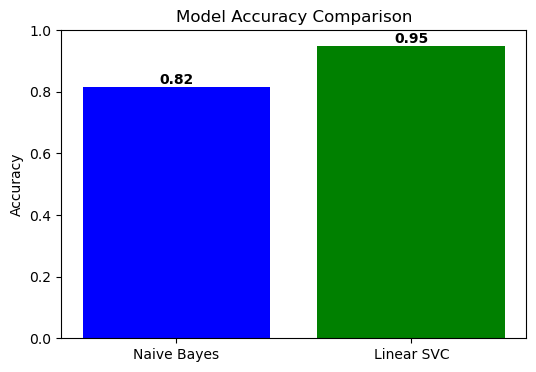

In [36]:
# ===========================
# Accuracy Comparison
# ===========================
acc_nb = accuracy_score(y_test, y_pred_nb)
acc_svm = accuracy_score(y_test, y_pred_svm)

plt.figure(figsize=(6,4))
plt.bar(['Naive Bayes', 'Linear SVC'], [acc_nb, acc_svm], color=['blue', 'green'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
for i, v in enumerate([acc_nb, acc_svm]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

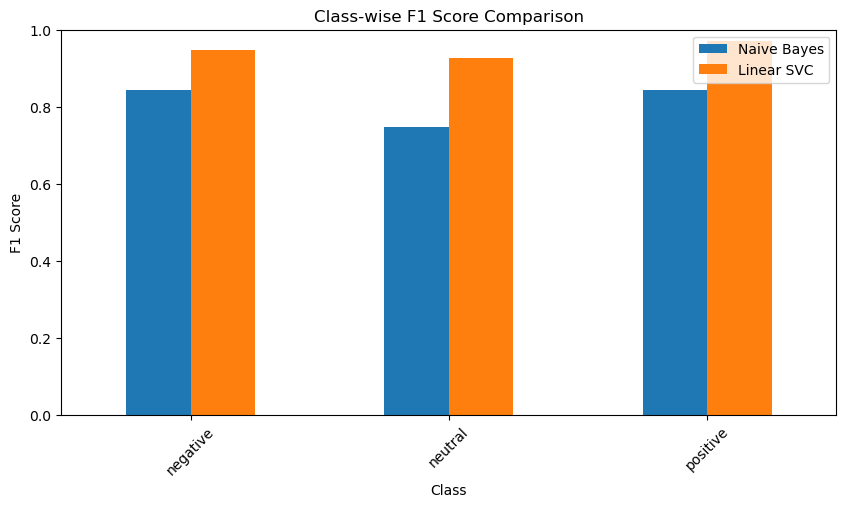

In [39]:
# ===========================
# Class-wise F1-Score Comparison
# ===========================
# Extract F1-scores from classification reports
report_nb = classification_report(y_test, y_pred_nb, output_dict=True)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)

classes = final_pipe.classes_  # <-- use your actual NB pipeline
f1_nb = [report_nb[cls]['f1-score'] for cls in classes]
f1_svm = [report_svm[cls]['f1-score'] for cls in classes]

df_f1 = pd.DataFrame({'Class': classes, 'Naive Bayes': f1_nb, 'Linear SVC': f1_svm})
df_f1 = df_f1.set_index('Class')

df_f1.plot(kind='bar', figsize=(10,5))
plt.ylabel("F1 Score")
plt.title("Class-wise F1 Score Comparison")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()

In [38]:
from sklearn.metrics import accuracy_score

# Naive Bayes training accuracy
y_train_pred_nb = final_pipe.predict(X_train)
acc_train_nb = accuracy_score(y_train, y_train_pred_nb)
print(f"Naive Bayes Training Accuracy: {acc_train_nb:.4f}")

# LinearSVC training accuracy
y_train_pred_svm = final_pipe_svm.predict(X_train)
acc_train_svm = accuracy_score(y_train, y_train_pred_svm)
print(f"Linear SVC Training Accuracy: {acc_train_svm:.4f}")


Naive Bayes Training Accuracy: 0.8311
Linear SVC Training Accuracy: 0.9588


In [40]:
import pandas as pd

# Create a DataFrame for analysis
df_analysis = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_nb": y_pred_nb,
    "pred_svm": y_pred_svm
})

# Find rows where NB and SVM disagree
df_disagree = df_analysis[df_analysis['pred_nb'] != df_analysis['pred_svm']]
print(f"Number of disagreements: {len(df_disagree)}")


Number of disagreements: 3259


In [41]:
# NB wrong, SVM correct
nb_wrong_svm_right = df_analysis[(df_analysis['pred_nb'] != df_analysis['true_label']) &
                                 (df_analysis['pred_svm'] == df_analysis['true_label'])]

# SVM wrong, NB correct
svm_wrong_nb_right = df_analysis[(df_analysis['pred_svm'] != df_analysis['true_label']) &
                                 (df_analysis['pred_nb'] == df_analysis['true_label'])]

print(f"NB wrong, SVM right: {len(nb_wrong_svm_right)}")
print(f"SVM wrong, NB right: {len(svm_wrong_nb_right)}")


NB wrong, SVM right: 2777
SVM wrong, NB right: 248


In [44]:
from tabulate import tabulate

# NB wrong, SVM correct
print("\n--- NB wrong, SVM correct ---")
nb_wrong_svm_right_sample = nb_wrong_svm_right[['text', 'true_label', 'pred_nb', 'pred_svm']].sample(5, random_state=42)
print(tabulate(nb_wrong_svm_right_sample, headers='keys', tablefmt='fancy_grid', showindex=False))

# SVM wrong, NB correct
print("\n--- SVM wrong, NB correct ---")
svm_wrong_nb_right_sample = svm_wrong_nb_right[['text', 'true_label', 'pred_nb', 'pred_svm']].sample(5, random_state=42)
print(tabulate(svm_wrong_nb_right_sample, headers='keys', tablefmt='fancy_grid', showindex=False))


--- NB wrong, SVM correct ---
╒═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════╤═══════════╤════════════╕
│ text                                                                                                                                                                                                                                                                                          │ true_label   │ pred_nb   │ pred_svm   │
╞═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪══════════════╪═════

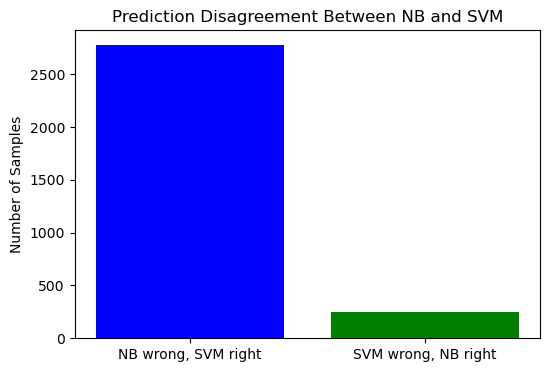

In [43]:
import matplotlib.pyplot as plt

# Count of disagreements
counts = [len(nb_wrong_svm_right), len(svm_wrong_nb_right)]
labels = ["NB wrong, SVM right", "SVM wrong, NB right"]

plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=["blue","green"])
plt.ylabel("Number of Samples")
plt.title("Prediction Disagreement Between NB and SVM")
plt.show()


In [45]:
df_balanced.head()

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,title,brand,clean_text,cleaned_text,vader_label,textblob_label,label,preprocessed_text
13,5.0,True,A107O6W0Q98CAT,7391002801,Suzanne Henderson #1410864,met expectations,met expectations,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,met expectations,met expectations,neutral,neutral,neutral,met expectations
17,5.0,True,A1EHXZBPIPARC2,7391002801,Guillermo Chavez,Excelente!!!,Five Stars,Silver Elegant Butterfly Foot Ankle Chain Summ...,Accessory,excelente,excelente,neutral,neutral,neutral,excelente
39,3.0,True,A2XPAU57KKYYRQ,7508492919,SmithIII,Everything came as it was supposed to but not ...,Durability,MinisDesign 3d Bling Crystal Bow Transparent C...,ELEGANI,everything came as it was supposed to but not ...,everything came supposed durable case rhinesto...,neutral,neutral,neutral,everything came supposed durable case rhinesto...
108,1.0,True,ATFNF6ZCX0KLZ,7508492919,Pen Name,it said it would take 4-17 days as it is and t...,I NEVER GOT THE PHONE CASE!!!!,MinisDesign 3d Bling Crystal Bow Transparent C...,ELEGANI,it said it would take days as it is and then a...,said would take days month another mother neve...,neutral,neutral,neutral,said would take days month another mother neve...
140,1.0,True,A317T1S6EM6G23,7508492919,The Sound,The bow fell off multiple times I had to keep ...,Don't waste your money or invest in glue,MinisDesign 3d Bling Crystal Bow Transparent C...,ELEGANI,the bow fell off multiple times i had to keep ...,bow fell multiple times keep gluing back would...,neutral,neutral,neutral,bow fell multiple times keep gluing back would...


In [46]:
df_balanced.size

1439265

In [48]:
df_balanced.shape

(95951, 15)

In [51]:
file_path = r"C:\Users\oalba\OneDrive\Desktop\df_balanced.xlsx"
df_balanced.to_excel(file_path, index=False)

### Training data

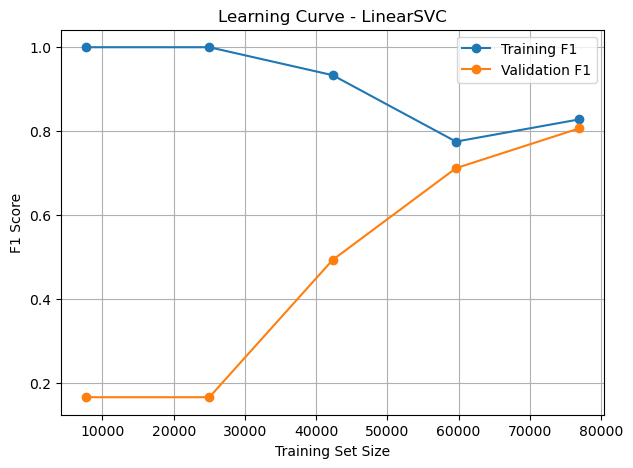

NameError: name 'nb_pipe' is not defined

In [103]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        cv=5, scoring='f1_macro',
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, 'o-', label="Training F1")
    plt.plot(train_sizes, val_mean, 'o-', label="Validation F1")
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example for SVM
plot_learning_curve(final_pipe, X, y, "Learning Curve - LinearSVC")

# Example for Naïve Bayes
plot_learning_curve(nb_pipe, X, y, "Learning Curve - MultinomialNB")


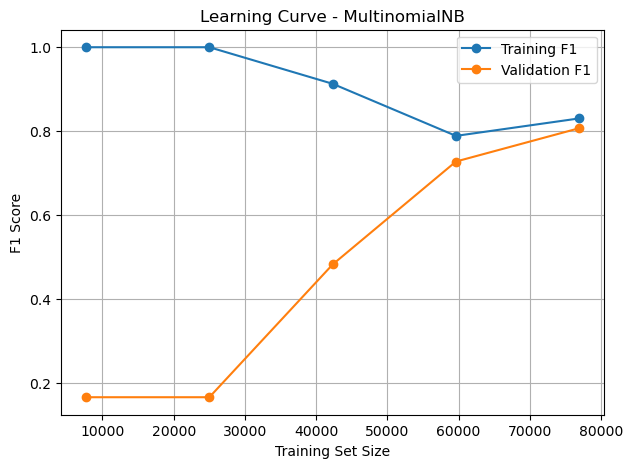

In [105]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB

# Naïve Bayes pipeline (TF-IDF + Chi²(k=5000) -> MNB)
nb_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=5000,        # adjust if needed
        ngram_range=(1,2),        # unigrams + bigrams
        lowercase=True,
        stop_words=None           # set to 'english' if appropriate
    )),
    ("chi2", SelectKBest(chi2, k=5000)),
    ("nb", MultinomialNB(alpha=1.0))  # tune alpha if needed
])

# now your existing call will work:
plot_learning_curve(nb_pipe, X, y, "Learning Curve - MultinomialNB")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\oalba\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


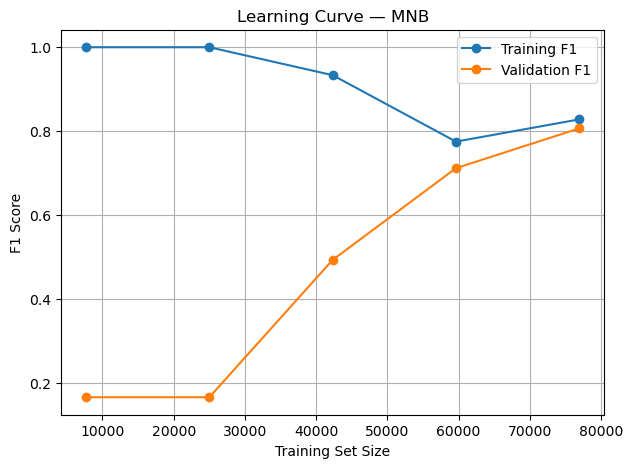

In [106]:
# --- imports you need above your classes ---
import re, numpy as np, pandas as pd
from scipy.sparse import csr_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# NLTK bits
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import opinion_lexicon

# one-time downloads (run once; comment out after it succeeds)
nltk.download('punkt')
# depending on your NLTK version, you may need one of these:
# nltk.download('averaged_perceptron_tagger') 
# nltk.download('averaged_perceptron_tagger_eng')
nltk.download('opinion_lexicon')


def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        cv=5, scoring='f1_macro',
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=1  # keep 1 because NLTK tokenization isn't thread-safe across processes
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, 'o-', label="Training F1")
    plt.plot(train_sizes, val_mean, 'o-', label="Validation F1")
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# run learning curve for your NB (with all features)
plot_learning_curve(final_pipe, X, y, "Learning Curve — MNB")



<Figure size 500x400 with 0 Axes>

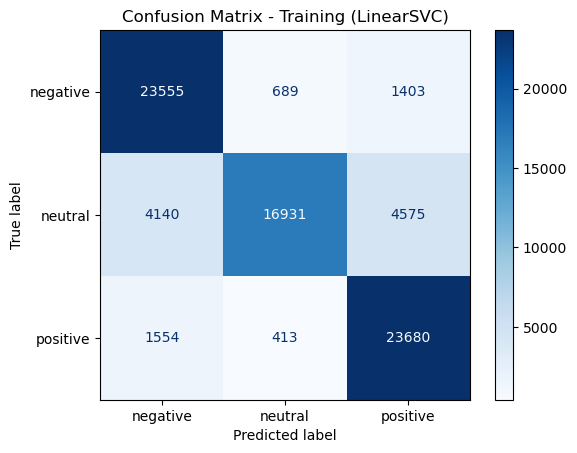

<Figure size 500x400 with 0 Axes>

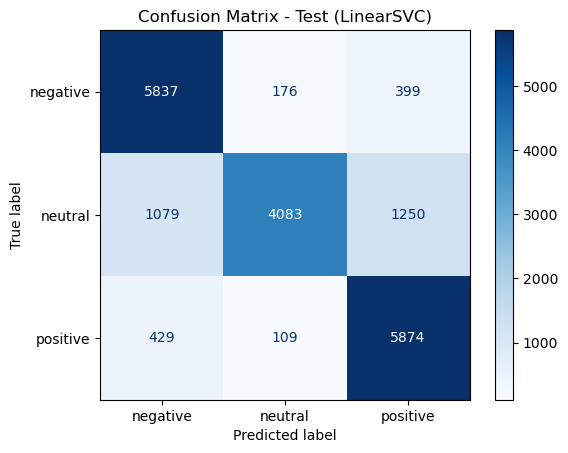

In [104]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Training Predictions ---
y_train_pred = final_pipe.predict(X_train)
cm_train = confusion_matrix(y_train, y_train_pred, labels=final_pipe.classes_)

plt.figure(figsize=(5,4))
ConfusionMatrixDisplay(cm_train, display_labels=final_pipe.classes_).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Training (LinearSVC)")
plt.show()

# --- Test Predictions ---
y_test_pred = final_pipe.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred, labels=final_pipe.classes_)

plt.figure(figsize=(5,4))
ConfusionMatrixDisplay(cm_test, display_labels=final_pipe.classes_).plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test (LinearSVC)")
plt.show()

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices_train_test(estimator, X_train, y_train, X_test, y_test,
                                       title_prefix="", normalize=False, cmap="Blues"):
    """
    Fits estimator (if not already fit), then plots Train and Test confusion matrices side by side.
    Works with sklearn Pipelines; uses estimator.classes_ for consistent label order.
    """
    # Fit if needed
    try:
        _ = estimator.classes_
        fitted = True
    except AttributeError:
        fitted = False
    if not fitted:
        estimator.fit(X_train, y_train)

    # Predictions
    y_pred_train = estimator.predict(X_train)
    y_pred_test  = estimator.predict(X_test)

    # Labels (consistent ordering)
    labels = estimator.classes_
    cm_train = confusion_matrix(y_train, y_pred_train, labels=labels, normalize=("true" if normalize else None))
    cm_test  = confusion_matrix(y_test,  y_pred_test,  labels=labels, normalize=("true" if normalize else None))

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    fmt = ".2f" if normalize else "d"

    sns.heatmap(cm_train, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title(f"{title_prefix} Training Confusion Matrix")
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

    sns.heatmap(cm_test, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title(f"{title_prefix} Test Confusion Matrix")
    axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


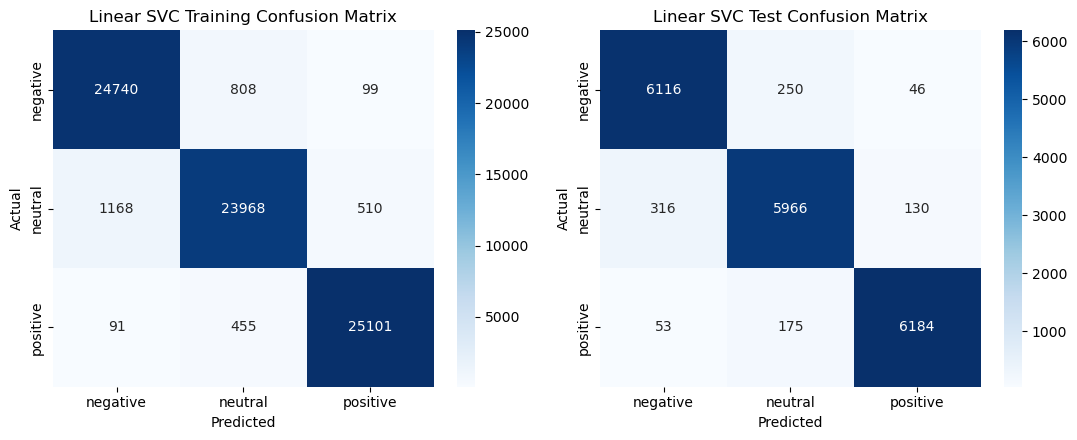

In [111]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# If you already built `combined_features` (TF-IDF+Chi² + POS + Review + Polarity), reuse it:
svm_pipe = Pipeline([
    ("features", combined_features),   # <-- from your NB setup
    ("svm", LinearSVC(C=1.0))          # tune C if needed
])

# Now plot Train vs Test confusion matrices for SVM
plot_confusion_matrices_train_test(
    svm_pipe,
    X_train, y_train,
    X_test, y_test,
    title_prefix="Linear SVC",
    normalize=False  # set True for row percentages
)


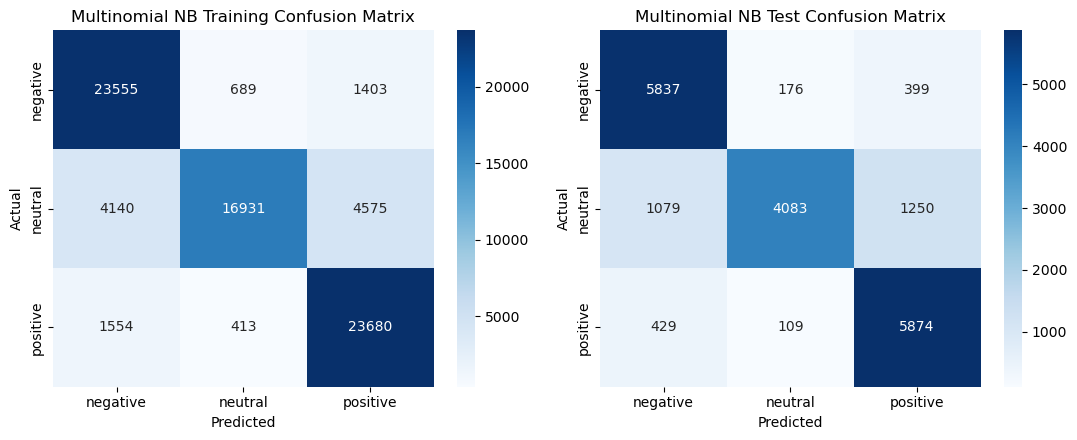

In [112]:
from sklearn.naive_bayes import MultinomialNB

# Naïve Bayes pipeline using the same combined features
nb_pipe = Pipeline([
    ("features", combined_features),   # TF-IDF + Chi² + POS + Review + Polarity
    ("nb", MultinomialNB(alpha=1.0))   # tune alpha if needed
])

# Plot Train vs Test confusion matrices for Naïve Bayes
plot_confusion_matrices_train_test(
    nb_pipe,
    X_train, y_train,
    X_test, y_test,
    title_prefix="Multinomial NB",
    normalize=False  # set True for row percentages
)


In [113]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report
)

def evaluate_on_test(estimator, X_test, y_test, model_name="Model"):
    """
    Evaluate a fitted estimator on the TEST set.
    Prints a per-class classification report and returns a one-row summary DataFrame.
    """
    # predict
    y_pred = estimator.predict(X_test)

    # accuracy
    acc = accuracy_score(y_test, y_pred)

    # aggregated averages
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(
        y_test, y_pred, average="micro", zero_division=0
    )
    p_wgt, r_wgt, f1_wgt, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )

    # per-class report (nice, readable text)
    print(f"\n=== {model_name} – Test Classification Report ===")
    print(classification_report(y_test, y_pred, digits=2, zero_division=0))

    # compact summary row
    summary = pd.DataFrame([{
        "model": model_name,
        "accuracy": acc,
        "precision_macro": p_macro, "recall_macro": r_macro, "f1_macro": f1_macro,
        "precision_micro": p_micro, "recall_micro": r_micro, "f1_micro": f1_micro,
        "precision_weighted": p_wgt, "recall_weighted": r_wgt, "f1_weighted": f1_wgt,
    }])

    return summary

# ── Usage ──────────────────────────────────────────────────────────────
# assumes you already have: X_test, y_test, svm_pipe, nb_pipe (fitted)

svm_summary = evaluate_on_test(svm_pipe, X_test, y_test, model_name="Linear SVC")
nb_summary  = evaluate_on_test(nb_pipe,  X_test, y_test, model_name="Multinomial NB")

# Combine summaries (nice for a quick comparison table)
all_summaries = pd.concat([svm_summary, nb_summary], ignore_index=True)
print("\n=== Test Metrics Summary ===")
print(all_summaries.round(3))



=== Linear SVC – Test Classification Report ===
              precision    recall  f1-score   support

    negative       0.94      0.95      0.95      6412
     neutral       0.93      0.93      0.93      6412
    positive       0.97      0.96      0.97      6412

    accuracy                           0.95     19236
   macro avg       0.95      0.95      0.95     19236
weighted avg       0.95      0.95      0.95     19236


=== Multinomial NB – Test Classification Report ===
              precision    recall  f1-score   support

    negative       0.79      0.91      0.85      6412
     neutral       0.93      0.64      0.76      6412
    positive       0.78      0.92      0.84      6412

    accuracy                           0.82     19236
   macro avg       0.84      0.82      0.82     19236
weighted avg       0.84      0.82      0.82     19236


=== Test Metrics Summary ===
            model  accuracy  precision_macro  recall_macro  f1_macro  \
0      Linear SVC     0.950       

In [115]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report
)

def evaluate_on_train(estimator, X_train, y_train, model_name="Model"):
    """
    Evaluate a fitted estimator on the TRAIN set.
    Prints a per-class classification report and returns a one-row summary DataFrame.
    """
    # predict on training data
    y_pred_tr = estimator.predict(X_train)

    # accuracy
    acc = accuracy_score(y_train, y_pred_tr)

    # aggregates
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        y_train, y_pred_tr, average="macro", zero_division=0
    )
    p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(
        y_train, y_pred_tr, average="micro", zero_division=0
    )
    p_wgt, r_wgt, f1_wgt, _ = precision_recall_fscore_support(
        y_train, y_pred_tr, average="weighted", zero_division=0
    )

    # nice per-class table
    print(f"\n=== {model_name} – Train Classification Report ===")
    print(classification_report(y_train, y_pred_tr, digits=2, zero_division=0))

    # compact summary row
    summary = pd.DataFrame([{
        "model": model_name + " (train)",
        "accuracy": acc,
        "precision_macro": p_macro, "recall_macro": r_macro, "f1_macro": f1_macro,
        "precision_micro": p_micro, "recall_micro": r_micro, "f1_micro": f1_micro,
        "precision_weighted": p_wgt, "recall_weighted": r_wgt, "f1_weighted": f1_wgt,
    }])

    return summary


In [116]:
# Assuming svm_pipe and nb_pipe are already fitted, and X_train, y_train exist

svm_train_summary = evaluate_on_train(svm_pipe, X_train, y_train, model_name="Linear SVC")
nb_train_summary  = evaluate_on_train(nb_pipe,  X_train, y_train, model_name="Multinomial NB")

# Optional: compare in one table
train_summary_tbl = pd.concat([svm_train_summary, nb_train_summary], ignore_index=True)
print("\n=== Train Metrics Summary ===")
print(train_summary_tbl.round(3))


=== Linear SVC – Train Classification Report ===
              precision    recall  f1-score   support

    negative       0.95      0.96      0.96     25647
     neutral       0.95      0.93      0.94     25646
    positive       0.98      0.98      0.98     25647

    accuracy                           0.96     76940
   macro avg       0.96      0.96      0.96     76940
weighted avg       0.96      0.96      0.96     76940


=== Multinomial NB – Train Classification Report ===
              precision    recall  f1-score   support

    negative       0.81      0.92      0.86     25647
     neutral       0.94      0.66      0.78     25646
    positive       0.80      0.92      0.86     25647

    accuracy                           0.83     76940
   macro avg       0.85      0.83      0.83     76940
weighted avg       0.85      0.83      0.83     76940


=== Train Metrics Summary ===
                    model  accuracy  precision_macro  recall_macro  f1_macro  \
0      Linear SVC (trai